In [1]:
# 1. Import libraries:
%matplotlib inline
import os
import quandl
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as spo
from scipy.stats import kurtosis, skew
import seaborn as sns
# from financial_data import *
import tensorflow as tf
mlp.style.use('seaborn')
quandl.save_key('HtwBLPt3k37yZHTvy15K')

/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_13390/4242266090.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mlp.style.use('seaborn')


In [2]:
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500 = pd.read_html(sp_url, header=0)[0]
sp500.head()



,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [3]:
# Correct invalid dates:
sp500.loc[sp500[sp500['Date added']=='1983-11-30 (1957-03-04)'].index,'Date added'] = '1983-11-30'
sp500.loc[sp500[sp500['Date added']=='2001?'].index,'Date added'] = '2001-01-01'
# Filter firms that entered the index after December 2015:
sp500['Date added'] = pd.to_datetime(sp500['Date added'],format='%Y-%m-%d')
sp500 = sp500[sp500['Date added']<'2007-01-01']
print("The number of stocks in the universe is:", sp500.shape[0])

The number of stocks in the universe is: 241


In [4]:
n_stocks = 10
np.random.seed(1792)
universe_tickers = sp500['Symbol'].unique()
tickers = list(np.random.choice(universe_tickers,replace=False,size=n_stocks))
print(tickers)
# sp500[sp500['Symbol'].isin(portfolio_tickers)]

['DIS', 'BIIB', 'PGR', 'SWK', 'PEP', 'ZION', 'LUV', 'BBWI', 'TFC', 'CBRE']


In [5]:
# tickers = ['AAPL', 'GOOGL', 'MSFT','SPY']
# start_date='2007-01-01'
# end_date='2022-12-31'
# columns = ['Adj Close', 'Volume']
# # Download data
# data = yf.download(tickers, start=start_date, end=end_date)[columns]

# # 'data' will be a Pandas DataFrame containing the historical data for the specified tickers
# print(data)


def download_data(tickers, start_date, end_date, columns):
    data = yf.download(tickers, start=start_date, end=end_date)
    data=data[columns]
    return data

# Define the tickers, start date, end date, and columns you want to download
# tickers = ['AAPL', 'GOOGL', 'MSFT']
start_date = '2007-01-01'
end_date = '2022-12-31'
columns = [ 'Adj Close', 'Volume','Open','High','Low']

# Download the data
data = download_data(tickers, start_date, end_date, columns)
print(data)


def one_lvl_colnames(df,cols,tickers):
    """This function changes a multi-level column indexation into a one level
    column indexation

    Inputs:
    -------
    df (pandas Dataframe): dataframe with the columns whose indexation will be 
        flattened.
    tickers (list|string): list/string with the tickers (s) in the data frame df.
    cols (list|string): list/string with the name of the columns (e.g. 'Adj Close',
        'High', 'Close', etc.) that are in the dataframe df.
    
    Ouputs:
    -------
    df (pandas Dataframe): dataframe with the same information as df, but 
        with one level of indexation.
    """
    
    
    print("the dataframe before the columns were renamed")
#     print(df.columns)
    df_not_renamed=df.copy()
#     df_not_renamed.drop("Open",inplace=True)
    print(df_not_renamed.columns)
    # Define important variables:
    if isinstance(tickers, str):
        tickers = [tickers]
    if isinstance(cols, str):
        
        cols = [cols]
        print(cols)

    # For multi-level column indexing:
    if isinstance(df.columns.values[0], tuple):

        # Define important varibles
        columns = df.columns.values
        new_cols = []

        # Itarate through the multi-level column names and flatten them:
        for col in columns:
            temp = []
            for name in col:
                if name != '':
                    temp.append(name)
            new_temp = '_'.join(temp)
            new_cols.append(new_temp)
        
        # Change the column names:
        df.columns = new_cols
        print(df.columns)
    
    # For uni-level colum indexing:
    elif isinstance(df.columns.values[0], str):
        
        # Define new names:
        col_names = [column+'_'+ticker for column in cols\
                     for ticker in tickers]
        df.columns = col_names
    
    print("the dataframe after the columns have been renamed") 
#     print(df)

    return df

df2=pd.DataFrame(one_lvl_colnames(data,cols=columns,tickers=tickers))
df2_columns=list(df2.columns)
df2.columns = [col.replace('Adj Close', 'Close') for col in df2_columns]
df2.fillna(method='ffill',inplace=True)
df2.fillna(method='bfill',inplace=True)
df2

[*********************100%%**********************]  10 of 10 completed
            Adj Close                                               \
                 BBWI        BIIB       CBRE        DIS        LUV   
Date                                                                 
2007-01-03  10.077239   49.330002  33.650002  28.317097  14.001652   
2007-01-04   9.317532   49.750000  33.340000  28.540649  14.218172   
2007-01-05   9.310717   49.759998  33.099998  28.308817  13.983607   
2007-01-08   9.130157   50.020000  33.220001  28.565493  14.236216   
2007-01-09   9.266430   49.500000  33.970001  28.524090  14.263284   
...               ...         ...        ...        ...        ...   
2022-12-23  41.287586  279.160004  76.669998  88.010002  35.322170   
2022-12-27  41.297436  274.769989  76.489998  86.370003  33.217911   
2022-12-28  40.116104  274.040009  75.410004  84.169998  31.505142   
2022-12-29  41.002106  276.000000  77.550003  87.180000  32.669830   
2022-12-30  41.4844

,Close_BBWI,Close_BIIB,Close_CBRE,Close_DIS,Close_LUV,Close_PEP,Close_PGR,Close_SWK,Close_TFC,Close_ZION,...,Low_BBWI,Low_BIIB,Low_CBRE,Low_DIS,Low_LUV,Low_PEP,Low_PGR,Low_SWK,Low_TFC,Low_ZION
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,10.077239,49.330002,33.650002,28.317097,14.001652,38.873489,13.782968,34.064186,23.917282,62.279121,...,23.540825,48.200001,33.139999,33.531136,15.350000,62.450001,24.070000,50.049999,43.630001,81.180000
2007-01-04,9.317532,49.750000,33.340000,28.540649,14.218172,39.139996,13.794351,34.278854,23.732466,62.557014,...,21.891672,48.880001,33.099998,33.708706,15.420000,62.500000,24.049999,50.259998,43.299999,82.550003
2007-01-05,9.310717,49.759998,33.099998,28.308817,13.983607,39.016041,13.521085,34.144691,23.417194,62.369225,...,21.147940,49.509998,32.799999,33.531136,15.420000,62.700001,23.600000,50.590000,42.990002,82.599998
2007-01-08,9.130157,50.020000,33.220001,28.565493,14.236216,39.102814,13.612178,34.017223,23.324783,62.474396,...,21.471302,48.910000,32.500000,33.610054,15.340000,62.860001,23.540001,49.950001,42.490002,82.150002
2007-01-09,9.266430,49.500000,33.970001,28.524090,14.263284,39.263954,13.378761,34.634384,23.281296,62.819939,...,21.827002,49.299999,33.060001,33.491676,15.700000,63.009998,23.440001,50.680000,42.580002,83.190002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,41.287586,279.160004,76.669998,88.010002,35.322170,178.524826,129.153381,71.870193,40.671665,46.701611,...,40.150002,276.070007,75.150002,85.769997,35.180000,180.449997,127.660004,72.599998,42.380001,47.990002
2022-12-27,41.297436,274.769989,76.489998,86.370003,33.217911,179.318237,129.881760,72.327049,40.910400,47.077538,...,41.810001,273.380005,76.099998,85.959999,33.650002,182.270004,129.190002,73.250000,42.340000,47.910000
2022-12-28,40.116104,274.040009,75.410004,84.169998,31.505142,178.025284,129.432770,70.159462,40.633465,46.238934,...,40.630001,272.640015,75.379997,84.070000,32.189999,181.639999,129.690002,72.160004,42.490002,47.939999


In [14]:
def momentum(prices):
    """This function finds the momentum metric for a group of assets.
    Inputs:
    -------
    prices (pandas dataframe|series): dataframe with the information of the
        prices of a group of assets or an indivitual asset.
    
    Outputs:
    --------
    momentum_df (pandas Dataframe): dataframe with the information of the
        momentum.
    """
    # Compute components:
    first = prices.iloc[0]
    last = prices.iloc[-1]

    # Compute momentum:
    momentum_df = last/first

    return momentum_df

def simple_moving_average(prices):
    """This function computes the simple moving average for a set of prices
    given a time window.

    Inputs:
    -------
    prices (pandas Dataframe|Series): dataframe with the information of the
        prices of the analyzed assets.

    Outputs:
    --------
    sma (pandas Dataframe): dataframe of the SMA of the assets' prices in
        the prices dataframe.
    """
    # Compute the SMA of the assets:
    mean = prices.mean()
    sma = prices[-1]/mean-1

    return sma
    
def bollinger_bands(prices):
    """This function computes the bollinger bands values for a set of assets
    returned in a pandas dataframe.

    Inputs:
    -------
    prices (pandas Dataframe|Series): dataframe with the price infromation
        of the assets analyzed.
    window (numeric value, default=None): determines if compute the BBs in
        a rolling manner, or if compute them to the whole input of prices.
    
    Outputs:
    --------
    bb (pandas dataframe): dataframe with the information of the bollinger
        bands of the assets in the prices dataframe.
    """
    # Compute components:
    ma = prices.mean()
    std = prices.std()

    # Compute bollinger bands:
    bb = (prices[-1]-ma)/(2*std)

    return bb


In [17]:
def rolling_statistics(df,cols='Adj Close',tickers=None,functions=None,
                      window=20,bollinger=False,roll_linewidth=1.5,**kwargs):
        '''This method extracts the rolling statistics from a time series, and
        can plot the rolling window with the data, adding the Bollinger bands.
        
        Inputs:
        -------
        column (string, default=None): the column from which you want compute 
            the rolling function.
        tickers (str|list, default=None): the ticker(s) from which you want to know the 
            information.
        functions (function|string|list): function(s) that will be rolled through the 
            time series.
        window (int): the window of the rolling data
            
        OUTPUTS:
            rolled (pandas series): a series with the rolling statistics specified

        '''
        # Define important varibles:
#         df = self.df
#         if isinstance(tickers,type(None)):
#             tickers = self.get_tickers()
        col_names = cols
        if isinstance(functions,type(None)):
            functions = [momentum, simple_moving_average, bollinger_bands]
        elif not isinstance(functions,list):
            functions = [functions]

        # Define the actual dataframe analized
        df = df[col_names]
#         print(df)

        # Compute the rolling statistics:
        rolling_stats = df.rolling(window).agg(functions)
        
        return rolling_stats
        
#         print(rolling_stats)


In [18]:
from stockstats import StockDataFrame
def extract_and_wrap_ticker_data(df, columns):
    # Split column names into parts
    parts = [col.split('_') for col in columns]

    # Create a dictionary to store information about each ticker
    ticker_info = {}

    # Iterate through the parts list
    for part in parts:
        data_type = part[0]  # e.g., 'Adj Close', 'Close', etc.
        ticker = part[1]     # e.g., 'AAPL', 'GOOGL', etc.

        # Check if the ticker is already in the dictionary
        if ticker not in ticker_info:
            ticker_info[ticker] = {}

        # Add information for the ticker
        ticker_info[ticker][data_type] = df[f'{data_type}_{ticker}']

    # Create a dictionary to store stockstats DataFrames for each ticker
    ticker_dataframes = pd.DataFrame()
#     var_importance_all=

    # Iterate through ticker_info and wrap data with stockstats
    for ticker, data in ticker_info.items():
        print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
        df = pd.DataFrame(data)
        print(ticker)
#         print(df)
        
        stock_df = StockDataFrame.retype(df)
#         print(stock_df)


        stock_df['cci_14']
        stock_df['stochrsi_14']
#         stock_df['ichimoku cloud']=stock_df['ichimoku cloud']
        stock_df['mfi_14']
        stock_df['bop_14']
        stock_df['supertrend_14']
        stock_df['eribull_14']
#         stock_df['cti_14']
#         stock_df['qqe_14']
        stock_df['ker_14']
        print(stock_df.head(26))
        roll_stat=rolling_statistics(stock_df,cols='close',
                      window=14)
        stock_df = pd.concat([stock_df,roll_stat],axis=1)
        print("&&&&&&&&&&&&&&&&&&&&&&&&")
        
        

        stock_df.columns = [ticker+"_" + col for col in pd.DataFrame(stock_df).columns]
        ticker_dataframes = pd.concat([ticker_dataframes,stock_df],axis=1)
        
    return ticker_dataframes

# Sample DataFrame with specified columns
columns = list(df2.columns)



# Extract and wrap ticker data
ticker_dataframes = extract_and_wrap_ticker_data(df2, columns)

# Access information for a specific ticker (e.g., AAPL)
# print(ticker_dataframes)

ticker_dataframes

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BBWI
                close    volume       open       high        low      cci_14  \
Date                                                                           
2007-01-03  10.077239   9288633  24.252222  24.276476  23.540825         NaN   
2007-01-04   9.317532  17476831  22.546482  22.756668  21.891672  -66.666667   
2007-01-05   9.310717   9970096  21.980598  22.433306  21.147940  -68.036282   
2007-01-08   9.130157   9207238  22.029102  22.465643  21.471302  -53.794551   
2007-01-09   9.266430  10808659  21.843168  22.465643  21.827002  -33.004947   
2007-01-10   9.177852   5218037  21.891672  21.891672  21.535975  -71.427884   
2007-01-11   9.545781   8770577  21.883589  22.789005  21.859337    9.747085   
2007-01-12   9.750189   5945764  22.635408  23.241714  22.530315   69.965750   
2007-01-16   9.590069   5575406  22.991108  23.185125  22.716249   58.354482   
2007-01-17   9.446983   6431163  22.716249  22.716249  22.320129    6.521029  

,BBWI_close,BBWI_volume,BBWI_open,BBWI_high,BBWI_low,BBWI_cci_14,BBWI_stochrsi_14,BBWI_mfi_14,BBWI_bop_14,BBWI_supertrend_14_ub,...,ZION_mfi_14,ZION_bop_14,ZION_supertrend_14_ub,ZION_supertrend_14_lb,ZION_supertrend_14,ZION_eribull_14,ZION_ker_14,ZION_momentum,ZION_simple_moving_average,ZION_bollinger_bands
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,10.077239,9288633,24.252222,24.276476,23.540825,NaN,NaN,0.500000,-19.268624,66.506361,...,0.500000,-10.283947,144.672646,19.627357,144.672646,20.840881,0.000000,NaN,NaN,NaN
2007-01-04,9.317532,17476831,22.546482,22.756668,21.891672,-66.666667,NaN,0.500000,-15.293656,62.557735,...,0.500000,-21.308477,144.672646,19.911251,144.672646,21.183826,1.000000,NaN,NaN,NaN
2007-01-05,9.310717,9970096,21.980598,22.433306,21.147940,-68.036282,NaN,0.500000,-9.857022,61.706631,...,0.500000,-36.965327,144.672646,20.233778,144.672646,20.836756,0.193486,NaN,NaN,NaN
2007-01-08,9.130157,9207238,22.029102,22.465643,21.471302,-53.794551,NaN,0.500000,-12.972357,61.706631,...,0.500000,-18.995900,144.672646,20.233778,144.672646,20.876601,0.342074,NaN,NaN,NaN
2007-01-09,9.266430,10808659,21.843168,22.465643,21.827002,-33.004947,100.000000,0.500000,-19.692959,61.706631,...,0.500000,-37.182233,144.672646,20.573468,144.672646,21.333059,0.590156,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,41.287586,2461500,40.330002,41.950001,40.150002,-26.952911,50.075488,0.271783,0.531992,46.013339,...,0.503874,-2.321171,53.253923,40.857792,53.253923,2.522172,0.003709,1.027790,0.023988,0.640840
2022-12-27,41.297436,3022500,41.939999,42.889999,41.810001,46.300354,50.367993,0.338524,-0.594967,46.013339,...,0.575792,-1.299558,53.253923,41.058295,53.253923,2.848211,0.236112,1.038045,0.029589,0.721970
2022-12-28,40.116104,2138000,41.779999,42.169998,40.630001,-29.822240,6.012646,0.345384,-1.080453,46.013339,...,0.617888,-2.740685,53.253923,41.105389,53.253923,2.632594,0.115289,1.012453,0.009849,0.239927


In [19]:
# Define the tickers
new_tickers = ['EIA/PET_RWTC_D','FRED/T10Y2Y','FRED/T10Y3M','FRED/DTB3','FRED/DLTIIT','FRED/TEDRATE']

# # Define the date range
# start='2020-01-01'
# end='2021-01-01'
names = ['wti_spot','10y2y_spread','10y3m_spread','3m_rate','ltiit','ted_spread']
# add_factors = quandl.get(tickers, start=start_date, end=end_date)

# # Retrieve data
data_quandl = quandl.get(new_tickers, start_date=start_date, end_date=end_date)
data_quandl.columns = names
data_quandl['var_wti'] = data_quandl['wti_spot'].pct_change()
# print(data_quandl)

# # Fill NaN values:
# data_quandl.fillna(method='ffill',inplace=True)
# data_quandl.fillna(method='bfill',inplace=True)


# # Print the data
print(data_quandl)



            wti_spot  10y2y_spread  10y3m_spread  3m_rate  ltiit  ted_spread  \
Date                                                                           
2007-01-02     60.77         -0.12         -0.39     4.94   2.33        0.42   
2007-01-03     58.31         -0.09         -0.38     4.92   2.32        0.44   
2007-01-04     55.65         -0.09         -0.42     4.91   2.30        0.45   
2007-01-05     56.29         -0.11         -0.40     4.92   2.33        0.44   
2007-01-08     56.08         -0.12         -0.42     4.95   2.34        0.41   
...              ...           ...           ...      ...    ...         ...   
2022-07-12       NaN         -0.07          0.74     2.16   1.12         NaN   
2022-07-13       NaN         -0.22          0.52     2.33   1.06         NaN   
2022-07-14       NaN         -0.19          0.56     2.33   1.07         NaN   
2022-07-15       NaN         -0.20          0.56     2.29   1.03         NaN   
2022-07-18       NaN         -0.19      

In [20]:
final_df=pd.merge(ticker_dataframes.reset_index(),data_quandl.reset_index(),on=['Date'],how='inner')
# final_df=ticker_dataframes.copy()

# Fill NaN values:
# final_df.fillna(method='ffill',inplace=True)
# final_df.fillna(method='bfill',inplace=True)
final_df

,Date,BBWI_close,BBWI_volume,BBWI_open,BBWI_high,BBWI_low,BBWI_cci_14,BBWI_stochrsi_14,BBWI_mfi_14,BBWI_bop_14,...,ZION_momentum,ZION_simple_moving_average,ZION_bollinger_bands,wti_spot,10y2y_spread,10y3m_spread,3m_rate,ltiit,ted_spread,var_wti
0,2007-01-03,10.077239,9288633,24.252222,24.276476,23.540825,NaN,NaN,0.500000,-19.268624,...,NaN,NaN,NaN,58.31,-0.09,-0.38,4.92,2.32,0.44,-0.040481
1,2007-01-04,9.317532,17476831,22.546482,22.756668,21.891672,-66.666667,NaN,0.500000,-15.293656,...,NaN,NaN,NaN,55.65,-0.09,-0.42,4.91,2.30,0.45,-0.045618
2,2007-01-05,9.310717,9970096,21.980598,22.433306,21.147940,-68.036282,NaN,0.500000,-9.857022,...,NaN,NaN,NaN,56.29,-0.11,-0.40,4.92,2.33,0.44,0.011500
3,2007-01-08,9.130157,9207238,22.029102,22.465643,21.471302,-53.794551,NaN,0.500000,-12.972357,...,NaN,NaN,NaN,56.08,-0.12,-0.42,4.95,2.34,0.41,-0.003731
4,2007-01-09,9.266430,10808659,21.843168,22.465643,21.827002,-33.004947,100.000000,0.500000,-19.692959,...,NaN,NaN,NaN,55.65,-0.13,-0.42,4.95,2.35,0.41,-0.007668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3907,2022-07-12,26.133543,3131200,26.799999,27.610001,26.680000,-60.147031,71.722590,0.398109,-0.716619,...,0.955099,-0.025107,-0.656465,NaN,-0.07,0.74,2.16,1.12,NaN,0.000000
3908,2022-07-13,26.678602,3244200,26.450001,27.540001,26.080000,-57.069015,99.104697,0.413616,0.156576,...,0.975020,-0.033333,-0.808520,NaN,-0.22,0.52,2.33,1.06,NaN,0.000000
3909,2022-07-14,25.267288,4278500,26.870001,27.020000,25.809999,-93.255723,63.458153,0.423011,-1.324555,...,0.910182,-0.050377,-1.002122,NaN,-0.19,0.56,2.33,1.07,NaN,0.000000
3910,2022-07-15,26.775932,4123700,26.459999,27.680000,26.250000,-34.397938,100.000000,0.374416,0.220932,...,0.962365,-0.005737,-0.130583,NaN,-0.20,0.56,2.29,1.03,NaN,0.000000


In [21]:
final_df2=final_df.copy()
for ticker in tickers:
    final_df2[ticker+"_close"] = final_df2[ticker+"_close"].pct_change()
#     final_df.drop(columns=[ticker+"_adj close"],inplace=True)
    final_df2=final_df2.dropna(subset=[ticker+"_close",ticker+"_momentum",ticker+"_bollinger_bands"])
final_df2.set_index(['Date'],inplace=True)
final_df2.drop(columns=['wti_spot'],inplace=True)
final_df2

,BBWI_close,BBWI_volume,BBWI_open,BBWI_high,BBWI_low,BBWI_cci_14,BBWI_stochrsi_14,BBWI_mfi_14,BBWI_bop_14,BBWI_supertrend_14_ub,...,ZION_ker_14,ZION_momentum,ZION_simple_moving_average,ZION_bollinger_bands,10y2y_spread,10y3m_spread,3m_rate,ltiit,ted_spread,var_wti
Date,,,,,,,,,,,,,,,,,,,,,
2007-02-05,0.001751,3568003,23.055780,23.233629,22.926435,97.129259,100.000000,0.559890,-43.324430,61.163120,...,0.435594,1.027182,0.018154,0.716702,-0.11,-0.34,5.02,2.39,0.34,-0.005423
2007-02-06,0.019573,6720374,23.120453,23.678253,23.104284,157.611932,100.000000,0.675272,-22.967954,61.163120,...,0.468398,1.031791,0.019856,0.727985,-0.13,-0.37,5.01,2.39,0.35,0.003749
2007-02-07,0.004114,5023086,23.492319,24.155214,23.338722,184.858791,100.000000,0.681892,-16.551140,61.163120,...,0.490201,1.037123,0.018567,0.652141,-0.13,-0.41,5.02,2.38,0.34,-0.019691
2007-02-08,-0.008194,3266546,23.637833,23.759094,23.257881,113.131323,82.672656,0.700400,-27.415793,61.163120,...,0.528348,1.037202,0.013715,0.496373,-0.14,-0.43,5.03,2.37,0.33,0.034805
2007-02-09,-0.018932,5109923,23.565077,23.637833,23.023443,64.566839,48.626041,0.612201,-22.552091,61.163120,...,0.609964,1.041858,0.014501,0.564524,-0.13,-0.36,5.02,2.41,0.34,0.001673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-12,-0.002600,3131200,26.799999,27.610001,26.680000,-60.147031,71.722590,0.398109,-0.716619,32.801144,...,0.254973,0.955099,-0.025107,-0.656465,-0.07,0.74,2.16,1.12,NaN,0.000000
2022-07-13,0.020857,3244200,26.450001,27.540001,26.080000,-57.069015,99.104697,0.413616,0.156576,32.374991,...,0.266251,0.975020,-0.033333,-0.808520,-0.22,0.52,2.33,1.06,NaN,0.000000
2022-07-14,-0.052901,4278500,26.870001,27.020000,25.809999,-93.255723,63.458153,0.423011,-1.324555,31.841777,...,0.218217,0.910182,-0.050377,-1.002122,-0.19,0.56,2.33,1.07,NaN,0.000000


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
def check_var_importance(df,ticker):
    # Separate features (X) and target (y)
    # AAPL_df.drop(columns=["AAPL_cr"],inplace=True)
    df= df.dropna() 
    X = df  # Use relevant columns
    y = df[ticker+'_close']  # Target variable is 'Close'

    # Standardize features (optional but often recommended for neural networks)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Create sequences of length 5 for X and corresponding y for training
    X_train, y_train = [], []

    for i in range(5, len(X)):
        X_train.append(X[i-5:i])
        y_train.append(y[i])

    X_train, y_train = np.array(X_train), np.array(y_train)
#     print(X_train)
#     print("***************")
#     print(y_train)

    # Step 2: Check Variable Importance
    # Use RandomForestRegressor to determine importance
    rf = RandomForestRegressor(n_estimators=10)
    rf.fit(X_train.reshape(-1, 5 * X.shape[1]), y_train)

    # Get feature importances along with their corresponding feature names
    feature_importances = rf.feature_importances_
    feature_names = [col.split(ticker+"_")[-1] for col in df.columns]
#     print(feature_names)

    # Combine feature names with their importances
    feature_importance_info = list(zip(feature_names, feature_importances))

    # Sort the list by importance (in descending order)
    feature_importance_info.sort(key=lambda x: x[0])

    return pd.DataFrame(feature_importance_info,columns=['Features',ticker+'_Relative_Importance'])

    

In [23]:
final_df2.head(2)
feat_importance_all=pd.DataFrame()
for ticker in tickers:

    matching_columns = [col for col in final_df2.columns if ticker in col]
#     matching_columns.append([])
    # # Print matching columns
    # for col in matching_columns:
    #     print(col)

    temp_df=final_df2[matching_columns]
    feat_importance_temp=check_var_importance(temp_df,ticker)
    feat_importance_all=pd.concat([feat_importance_all,feat_importance_temp], axis=1)
#     print(feat_importance_all)
feat_importance_all=feat_importance_all.T.drop_duplicates(keep='first').T
feat_importance_all["Average_relative_Importance"]=feat_importance_all.iloc[:,1:].mean(axis=1)
print(feat_importance_all)
threshold = .01  # Example threshold value

# Create a boolean mask based on the condition
mask = feat_importance_all['Average_relative_Importance'] >= threshold

# Apply the mask to the DataFrame
filtered_df = feat_importance_all[mask]

# df['Average_Columns'] = df[['Column1', 'Column2']].mean(axis=1)
#     print(temp_df)

filtered_df.reset_index(drop=True,inplace=True)
filtered_df

                 Features DIS_Relative_Importance BIIB_Relative_Importance  \
0         bollinger_bands                0.008701                 0.005558   
1                  bop_14                 0.01115                 0.034658   
2                  cci_14                0.012515                 0.010502   
3                   close                0.046393                 0.019462   
4              eribull_14                 0.01012                 0.018783   
5                    high                0.005242                 0.003294   
6                  ker_14                0.012999                 0.015705   
7                     low                0.003171                 0.004664   
8                  mfi_14                0.011963                 0.042517   
9                momentum                0.019631                 0.008287   
10                   open                0.007208                 0.004785   
11  simple_moving_average                0.009434               

,Features,DIS_Relative_Importance,BIIB_Relative_Importance,PGR_Relative_Importance,SWK_Relative_Importance,PEP_Relative_Importance,ZION_Relative_Importance,LUV_Relative_Importance,BBWI_Relative_Importance,TFC_Relative_Importance,CBRE_Relative_Importance,Average_relative_Importance
0,bop_14,0.01115,0.034658,0.014757,0.014789,0.017913,0.014086,0.020513,0.012985,0.009001,0.011571,0.016142
1,cci_14,0.012515,0.010502,0.017664,0.00826,0.010023,0.016428,0.01153,0.01164,0.011633,0.009901,0.012009
2,close,0.046393,0.019462,0.04437,0.027619,0.037742,0.03264,0.025628,0.025663,0.031652,0.019922,0.031109
3,eribull_14,0.01012,0.018783,0.014069,0.042906,0.010319,0.009046,0.013363,0.010259,0.013735,0.008977,0.015158
4,ker_14,0.012999,0.015705,0.013093,0.013679,0.015937,0.011429,0.022097,0.021638,0.013658,0.007903,0.014814
5,mfi_14,0.011963,0.042517,0.009414,0.01182,0.013814,0.014534,0.01459,0.017209,0.012148,0.013393,0.016140
6,momentum,0.019631,0.008287,0.012366,0.025572,0.012631,0.028109,0.023645,0.031177,0.01756,0.02522,0.020420
7,simple_moving_average,0.009434,0.009297,0.013273,0.014972,0.009158,0.017969,0.012807,0.017762,0.023161,0.018685,0.014652
8,volume,0.018641,0.013938,0.015431,0.018969,0.019783,0.009878,0.015535,0.017234,0.011396,0.014022,0.015483


In [24]:
final_df2.head(2)

,BBWI_close,BBWI_volume,BBWI_open,BBWI_high,BBWI_low,BBWI_cci_14,BBWI_stochrsi_14,BBWI_mfi_14,BBWI_bop_14,BBWI_supertrend_14_ub,...,ZION_ker_14,ZION_momentum,ZION_simple_moving_average,ZION_bollinger_bands,10y2y_spread,10y3m_spread,3m_rate,ltiit,ted_spread,var_wti
Date,,,,,,,,,,,,,,,,,,,,,
2007-02-05,0.001751,3568003,23.055780,23.233629,22.926435,97.129259,100.0,0.559890,-43.324430,61.16312,...,0.435594,1.027182,0.018154,0.716702,-0.11,-0.34,5.02,2.39,0.34,-0.005423
2007-02-06,0.019573,6720374,23.120453,23.678253,23.104284,157.611932,100.0,0.675272,-22.967954,61.16312,...,0.468398,1.031791,0.019856,0.727985,-0.13,-0.37,5.01,2.39,0.35,0.003749


In [25]:
imp_col_names=[filtered_df['Features'].values][0].tolist()

# imp_col_names = [ticker +"_"+ element for element in imp_col_names]
final_col_names = []
for col in imp_col_names:
    for ticker in tickers:
        final_col_names.append(f'{ticker}_{col}')

print(final_col_names)

['DIS_bop_14', 'BIIB_bop_14', 'PGR_bop_14', 'SWK_bop_14', 'PEP_bop_14', 'ZION_bop_14', 'LUV_bop_14', 'BBWI_bop_14', 'TFC_bop_14', 'CBRE_bop_14', 'DIS_cci_14', 'BIIB_cci_14', 'PGR_cci_14', 'SWK_cci_14', 'PEP_cci_14', 'ZION_cci_14', 'LUV_cci_14', 'BBWI_cci_14', 'TFC_cci_14', 'CBRE_cci_14', 'DIS_close', 'BIIB_close', 'PGR_close', 'SWK_close', 'PEP_close', 'ZION_close', 'LUV_close', 'BBWI_close', 'TFC_close', 'CBRE_close', 'DIS_eribull_14', 'BIIB_eribull_14', 'PGR_eribull_14', 'SWK_eribull_14', 'PEP_eribull_14', 'ZION_eribull_14', 'LUV_eribull_14', 'BBWI_eribull_14', 'TFC_eribull_14', 'CBRE_eribull_14', 'DIS_ker_14', 'BIIB_ker_14', 'PGR_ker_14', 'SWK_ker_14', 'PEP_ker_14', 'ZION_ker_14', 'LUV_ker_14', 'BBWI_ker_14', 'TFC_ker_14', 'CBRE_ker_14', 'DIS_mfi_14', 'BIIB_mfi_14', 'PGR_mfi_14', 'SWK_mfi_14', 'PEP_mfi_14', 'ZION_mfi_14', 'LUV_mfi_14', 'BBWI_mfi_14', 'TFC_mfi_14', 'CBRE_mfi_14', 'DIS_momentum', 'BIIB_momentum', 'PGR_momentum', 'SWK_momentum', 'PEP_momentum', 'ZION_momentum', 'LUV_mo

In [26]:
final_col_names=final_col_names+['10y2y_spread','10y3m_spread','3m_rate','ltiit','ted_spread','var_wti']

In [27]:
final_col_names

['DIS_bop_14',
 'BIIB_bop_14',
 'PGR_bop_14',
 'SWK_bop_14',
 'PEP_bop_14',
 'ZION_bop_14',
 'LUV_bop_14',
 'BBWI_bop_14',
 'TFC_bop_14',
 'CBRE_bop_14',
 'DIS_cci_14',
 'BIIB_cci_14',
 'PGR_cci_14',
 'SWK_cci_14',
 'PEP_cci_14',
 'ZION_cci_14',
 'LUV_cci_14',
 'BBWI_cci_14',
 'TFC_cci_14',
 'CBRE_cci_14',
 'DIS_close',
 'BIIB_close',
 'PGR_close',
 'SWK_close',
 'PEP_close',
 'ZION_close',
 'LUV_close',
 'BBWI_close',
 'TFC_close',
 'CBRE_close',
 'DIS_eribull_14',
 'BIIB_eribull_14',
 'PGR_eribull_14',
 'SWK_eribull_14',
 'PEP_eribull_14',
 'ZION_eribull_14',
 'LUV_eribull_14',
 'BBWI_eribull_14',
 'TFC_eribull_14',
 'CBRE_eribull_14',
 'DIS_ker_14',
 'BIIB_ker_14',
 'PGR_ker_14',
 'SWK_ker_14',
 'PEP_ker_14',
 'ZION_ker_14',
 'LUV_ker_14',
 'BBWI_ker_14',
 'TFC_ker_14',
 'CBRE_ker_14',
 'DIS_mfi_14',
 'BIIB_mfi_14',
 'PGR_mfi_14',
 'SWK_mfi_14',
 'PEP_mfi_14',
 'ZION_mfi_14',
 'LUV_mfi_14',
 'BBWI_mfi_14',
 'TFC_mfi_14',
 'CBRE_mfi_14',
 'DIS_momentum',
 'BIIB_momentum',
 'PGR_momen

In [28]:
model_data=final_df2[final_col_names]
model_data

,DIS_bop_14,BIIB_bop_14,PGR_bop_14,SWK_bop_14,PEP_bop_14,ZION_bop_14,LUV_bop_14,BBWI_bop_14,TFC_bop_14,CBRE_bop_14,...,LUV_volume,BBWI_volume,TFC_volume,CBRE_volume,10y2y_spread,10y3m_spread,3m_rate,ltiit,ted_spread,var_wti
Date,,,,,,,,,,,,,,,,,,,,,
2007-02-05,-17.075763,-0.231710,-37.175131,-15.557579,-44.319380,-19.781446,-5.701382,-43.324430,-48.903791,0.139236,...,7286100,3568003,1937500,1558600,-0.11,-0.34,5.02,2.39,0.34,-0.005423
2007-02-06,-15.459108,-0.081969,-63.277943,-22.295886,-42.985149,-20.958373,-5.687057,-22.967954,-60.025535,-0.098765,...,7018700,6720374,1164400,2146900,-0.13,-0.37,5.01,2.39,0.35,0.003749
2007-02-07,-14.284782,0.610391,-48.795845,-25.842834,-50.882284,-29.466748,-9.059952,-16.551140,-83.568391,0.320224,...,6945300,5023086,1034700,3448700,-0.13,-0.41,5.02,2.38,0.34,-0.019691
2007-02-08,-5.632069,0.564706,-46.440357,-27.547278,-18.328859,-26.015268,-6.967289,-27.415793,-50.676600,0.082194,...,6835400,3266546,1070300,1572800,-0.14,-0.43,5.03,2.37,0.33,0.034805
2007-02-09,-4.609494,-0.245455,-27.631604,-15.479156,-14.433311,-22.820337,-6.964341,-22.552091,-47.461276,-0.575667,...,6758400,5109923,1602800,3252800,-0.13,-0.36,5.02,2.41,0.34,0.001673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-12,0.010308,-0.238938,-0.864706,-1.373918,-2.045917,-1.803389,0.180817,-0.716619,-1.991529,0.641791,...,8130800,3131200,3948000,2029500,-0.07,0.74,2.16,1.12,NaN,0.000000
2022-07-13,0.366072,0.589164,0.189750,-0.471402,-1.174611,-1.948663,0.377454,0.156576,-3.175125,-0.047060,...,10121900,3244200,4792400,2285100,-0.22,0.52,2.33,1.06,NaN,0.000000
2022-07-14,0.198891,0.269312,-0.669892,-1.868440,-0.856435,-2.680103,-0.561558,-1.324555,-4.036404,0.836601,...,5987800,4278500,6074200,1995200,-0.19,0.56,2.33,1.07,NaN,0.000000


In [29]:
class WindowGenerator():
    """This class takes time series data that is in a sequential format, transforming
    it into pairs of inputs and labels, so that the inputs are windows of consecutive
    samples from the data.
    """
    def __init__(self,input_width=5,label_width=1,shift=1, train_df=None, val_df=None,
                 test_df=None, label_columns=None,batch_size=None,shuffle=False):
        """This method initiates the WindowGenerator class.

        Inputs:
        -------
        input_width (int, default=5): the width of the window, which represents the 
            amount of time steps from the earliest input observation to the last.
        label_width (int, default=1): the width of the label. This determines the amount
             of time steps that will be predicted.
        shift (int, default=1): jump between the last input in the window and the first 
            label.
        train_df (pandas Dataframe, default=None): array-like object containing the train 
            data which comes in a time series format.
        val_df (pandas Dataframe, default=None): array-like object containing the 
            validation data.
        test_df (pandas Dataframe, default=None): array-like object containing the test 
            data.
        label_columns (list|string, default=None): name of the column(s) that are used 
            as labels.
        batch_size (int, deafault=None): the size of the batches of the tf.data.Dataset
            object (whose dimensions are (batch,input_width,features) for the input and
            (batch,label_width,label_columns) for the labels).
        shuffle (boolean, default=False): determines if the data inside the tf.data.Dataset
            is shuffled.
        
        Outputs:
        --------
        None
        """
        # Define attributes of the class:
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label_columns = label_columns
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Define information about columns:
        if isinstance(label_columns,type(None)):
            self.label_columns_indices = {name:i for i,name in enumerate(label_columns)}
        self.column_indices = {name:i for i,name in enumerate(train_df.columns)}

        # Define window information:
        self.total_window_size = input_width+shift
        self.input_slice = slice(0,input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size-self.label_width
        self.labels_slice = slice(self.label_start,None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def __repr__(self):
        """This method determines what is returned when an instance of the object
        is called
        """
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    def split_window(self, features):
        """This method converts a list of consecutive inputs to a window of
        inputs and a window of labels.

        Inputs:
        -------
        features (pandas Dataset): features in the dataframe

        Outputs:
        --------
        inputs ()
        """
        inputs = features[:, self.input_slice,:]
        labels = features[:,self.labels_slice,:]
        if not isinstance(self.label_columns,type(None)):
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis = -1
            )
        
        # Set the shapes of the informaiton:
        inputs.set_shape([None,self.input_width,None])
        labels.set_shape([None,self.label_width,None])

        return inputs,labels
    
    def make_dataset(self,data):
        """This method takes a time series DataFrame and convert it to a 
        tf.data.Dataset of (input_window,label_window) pairs, using the
        tf.keras.preprocessing.timeseries_dataset_from_array function.

        Input:
        ------
        data (pandas DataFrame): dataframe containing the time series information
            of the inputs and labels, which will transformed into windows and then 
            a tf.Dataset object.
        
        Outputs:
        --------

        """
        data = np.array(data,dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data = data,
            targets = None,
            sequence_length = self.total_window_size,
            sequence_stride = 1,
            shuffle = self.shuffle,
            batch_size = self.batch_size
        )
        ds = ds.map(self.split_window)
        print("************************************************")
        print(ds)

        return ds

    # Adding properties for accessing the train, val and test as tf.data.Dataset objects
    @property
    def train(self):
        if isinstance(self.train_df,type(None)):
            return None
        else:
            return self.make_dataset(self.train_df)
        print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")    
        print(self.train_df)

    @property
    def val(self):
        if isinstance(self.val_df,type(None)):
            return None
        else:
            return self.make_dataset(self.val_df)

    @property
    def test(self):
        if isinstance(self.test_df,type(None)):
            return None
        else:
            return self.make_dataset(self.test_df)
    

In [30]:
# Define the label columns:

# total_df=final_df2.copy()
# total_df.set_index('Date',inplace=True)
# label_cols = list(total_df.columns)
# label_cols=label_cols[:len(tickers)]



# matching_columns = [col for col in df.columns if "close" in col]
model_data.fillna(method='ffill',inplace=True)
model_data.fillna(method='bfill',inplace=True)

model_data
    
label_cols=[col for col in model_data.columns if "close" in col]
    
    
    
    
# ['AAPL_returns', 'GOOGL_returns', 'MSFT_returns', 'SPY_returns']
print(label_cols)

# Define train (70%), val (20%) and test (10%) dataframes: 
train_p, val_p, test_p = 0.7,0.2,0.1
window_size = 5
num_features = model_data.shape[1]
total_size = len(model_data)
train_size = int(total_size*train_p)
val_size = int(total_size*val_p)
test_size = int(total_size*test_p)
train_df = model_data.iloc[:train_size,:]
val_df = model_data.iloc[train_size-window_size:train_size+val_size,:]
test_df = model_data.iloc[train_size+val_size-window_size:,:]

['DIS_close', 'BIIB_close', 'PGR_close', 'SWK_close', 'PEP_close', 'ZION_close', 'LUV_close', 'BBWI_close', 'TFC_close', 'CBRE_close']


/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_13390/3367714174.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.fillna(method='ffill',inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_13390/3367714174.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.fillna(method='bfill',inplace=True)


In [31]:
model_data.columns

Index(['DIS_bop_14', 'BIIB_bop_14', 'PGR_bop_14', 'SWK_bop_14', 'PEP_bop_14',
       'ZION_bop_14', 'LUV_bop_14', 'BBWI_bop_14', 'TFC_bop_14', 'CBRE_bop_14',
       'DIS_cci_14', 'BIIB_cci_14', 'PGR_cci_14', 'SWK_cci_14', 'PEP_cci_14',
       'ZION_cci_14', 'LUV_cci_14', 'BBWI_cci_14', 'TFC_cci_14', 'CBRE_cci_14',
       'DIS_close', 'BIIB_close', 'PGR_close', 'SWK_close', 'PEP_close',
       'ZION_close', 'LUV_close', 'BBWI_close', 'TFC_close', 'CBRE_close',
       'DIS_eribull_14', 'BIIB_eribull_14', 'PGR_eribull_14', 'SWK_eribull_14',
       'PEP_eribull_14', 'ZION_eribull_14', 'LUV_eribull_14',
       'BBWI_eribull_14', 'TFC_eribull_14', 'CBRE_eribull_14', 'DIS_ker_14',
       'BIIB_ker_14', 'PGR_ker_14', 'SWK_ker_14', 'PEP_ker_14', 'ZION_ker_14',
       'LUV_ker_14', 'BBWI_ker_14', 'TFC_ker_14', 'CBRE_ker_14', 'DIS_mfi_14',
       'BIIB_mfi_14', 'PGR_mfi_14', 'SWK_mfi_14', 'PEP_mfi_14', 'ZION_mfi_14',
       'LUV_mfi_14', 'BBWI_mfi_14', 'TFC_mfi_14', 'CBRE_mfi_14',
       'DIS_mom

In [32]:
# Define the batch size:
batch_size = 512

# Create an instance of the WindowGenerator object:
my_window = WindowGenerator(input_width=window_size,label_width=1,shift=1,train_df=train_df,val_df=val_df,
                            test_df=test_df,label_columns=label_cols,
                            batch_size=batch_size,shuffle=True)
print(my_window)

# Print the shapes for one batch of each sub dataset:
for example_inputs, example_labels in my_window.train.take(1):
    print("Train input shape:",example_inputs.shape)
    print("Train target shape:",example_labels.shape)
for example_inputs, example_labels in my_window.val.take(1):
    print("Validation input shape:",example_inputs.shape)
    print("Validation target shape:",example_labels.shape)
for example_inputs, example_labels in my_window.test.take(1):
    print("Test input shape:",example_inputs.shape)
    print("Test target shape:",example_labels.shape)

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['DIS_close', 'BIIB_close', 'PGR_close', 'SWK_close', 'PEP_close', 'ZION_close', 'LUV_close', 'BBWI_close', 'TFC_close', 'CBRE_close']
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 96), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
Train input shape: (512, 5, 96)
Train target shape: (512, 1, 10)
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 96), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
Validation input shape: (512, 5, 96)
Validation target shape: (512, 1, 10)
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 96), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
Test input shape: (389, 5, 96)
Te

In [33]:
# import tensorflow as tf

# def initial_eda(dataset):
#     for batch in dataset.take(1):  # Assuming you want to analyze the first batch
#         print("Dimensions:", batch[0].shape[0], "samples,", batch[0].shape[1], "features")
#         print("Labels shape:", batch[1].shape)
#         print("Labels sample:", batch[1].numpy()[:5])  # Printing first 5 labels as an example
#         print("Features sample:", batch[0].numpy()[:5])
#         print("dataframe of the features")
#         print(pd.DataFrame(batch[0].numpy()[:5]))
# # Assuming my_window.train is your TensorFlow dataset
# initial_eda(my_window.train)

In [34]:
num_features

96

In [35]:
1e-8 * 10**(1/20)

1.1220184543019634e-08

In [36]:
1e-8 * 10**(100/20)

0.001

In [37]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Conv1D, LSTM, GRU, Input, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

# Define your learning rate scheduler function
def lr_schedule(epoch):
    initial_lr = 1e-8
    return initial_lr * 10**(epoch/20)



early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Stop training after no improvement for 10 epochs
    restore_best_weights=True,  # Restore the best weights when stopping
min_delta=0.0000001)

# Create a model (you need to replace this with your actual model)
model_1 = Sequential([
    BatchNormalization(
        input_shape = (window_size,num_features),
        name = 'Batch_Norm_1'),
    LSTM(512,return_sequences=True,name='LSTM_1'),
    LSTM(512,name='LSTM_2'),
    Dense(256,activation='relu',name='Dense_1'),
    Dense(len(tickers),name='Returns')
])


checkpont_rnn = ModelCheckpoint(
    filepath='model_inder_rnn999',
    save_weights_only=False,
    save_freq = 'epoch',
    monitor = 'val_loss',
    save_best_only = True,
    verbose = 1)

# Compile the model with an optimizer (Adam in this example)
optimizer = tf.keras.optimizers.Adam()  # Set initial learning rate to 0.0
model_1.compile(
    loss=tf.keras.losses.Huber(),
    metrics=[tf.metrics.RootMeanSquaredError(),'mae'],
    optimizer=optimizer)

# Set up the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Define the number of epochs
num_epochs = 100

# Initialize lists to store loss and learning rates
losses = []
learning_rates = []

# Custom callback to log loss and learning rate
class LossLearningRateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        loss = logs['loss']
        learning_rates.append(lr)
#         print(learning_rates)
        losses.append(loss)
        print()
        print(f"Epoch {epoch+1}: Learning Rate = {lr.numpy()}, Loss = {loss}")


# Create an instance of the custom callback
loss_lr_callback = LossLearningRateCallback()

# Train your model
# history = model.fit(x_train, y_train, epochs=num_epochs, callbacks=[lr_scheduler, loss_lr_callback])
history = model_1.fit(
    my_window.train,
    epochs=num_epochs,
    validation_data=my_window.val,
    callbacks=[lr_scheduler, loss_lr_callback, early_stopping, checkpont_rnn]
)

# Access the losses from the training history
losses = history.history['loss']


************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 96), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 96), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0736 - mae: 0.0579
Epoch 1: Learning Rate = 9.99999993922529e-09, Loss = 0.0027095370460301638

Epoch 1: val_loss improved from inf to 0.02110, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 4s 603ms/step - loss: 0.0027 - root_mean_squared_error: 0.0736 - mae: 0.0579 - val_loss: 0.0211 - val_root_mean_squared_error: 0.2054 - val_mae: 0.1486 - lr: 1.0000e-08
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0737 - mae: 0.0579
Epoch 2: Learning Rate = 1.122018478127984e-08, Loss = 0.002709662541747093

Epoch 2: val_loss improved from 0.02110 to 0.01880, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 515ms/step - loss: 0.0027 - root_mean_squared_error: 0.0737 - mae: 0.0579 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1939 - val_mae: 0.1350 - lr: 1.1220e-08
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0736 - mae: 0.0579
Epoch 3: Learning Rate = 1.2589254083650303e-08, Loss = 0.002712674904614687

Epoch 3: val_loss improved from 0.01880 to 0.01663, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 549ms/step - loss: 0.0027 - root_mean_squared_error: 0.0736 - mae: 0.0579 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1824 - val_mae: 0.1256 - lr: 1.2589e-08
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0736 - mae: 0.0579
Epoch 4: Learning Rate = 1.4125375535911644e-08, Loss = 0.0027066778857260942

Epoch 4: val_loss improved from 0.01663 to 0.01466, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 544ms/step - loss: 0.0027 - root_mean_squared_error: 0.0736 - mae: 0.0579 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1711 - val_mae: 0.1178 - lr: 1.4125e-08
Epoch 5/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0736 - mae: 0.0579
Epoch 5: Learning Rate = 1.5848931056439142e-08, Loss = 0.002705493476241827

Epoch 5: val_loss improved from 0.01466 to 0.01294, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 544ms/step - loss: 0.0027 - root_mean_squared_error: 0.0736 - mae: 0.0579 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1610 - val_mae: 0.1112 - lr: 1.5849e-08
Epoch 6/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0735 - mae: 0.0579
Epoch 6: Learning Rate = 1.7782793904075334e-08, Loss = 0.002706842264160514

Epoch 6: val_loss improved from 0.01294 to 0.01148, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 541ms/step - loss: 0.0027 - root_mean_squared_error: 0.0735 - mae: 0.0579 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1517 - val_mae: 0.1051 - lr: 1.7783e-08
Epoch 7/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0736 - mae: 0.0579
Epoch 7: Learning Rate = 1.9952622665186937e-08, Loss = 0.0027078415732830763

Epoch 7: val_loss improved from 0.01148 to 0.01026, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 556ms/step - loss: 0.0027 - root_mean_squared_error: 0.0736 - mae: 0.0579 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1432 - val_mae: 0.0998 - lr: 1.9953e-08
Epoch 8/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0736 - mae: 0.0579
Epoch 8: Learning Rate = 2.238721208414063e-08, Loss = 0.0027082390151917934

Epoch 8: val_loss improved from 0.01026 to 0.00923, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 547ms/step - loss: 0.0027 - root_mean_squared_error: 0.0736 - mae: 0.0579 - val_loss: 0.0092 - val_root_mean_squared_error: 0.1362 - val_mae: 0.0951 - lr: 2.2387e-08
Epoch 9/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0734 - mae: 0.0578
Epoch 9: Learning Rate = 2.5118863433704064e-08, Loss = 0.002703165402635932

Epoch 9: val_loss improved from 0.00923 to 0.00835, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 526ms/step - loss: 0.0027 - root_mean_squared_error: 0.0734 - mae: 0.0578 - val_loss: 0.0083 - val_root_mean_squared_error: 0.1295 - val_mae: 0.0909 - lr: 2.5119e-08
Epoch 10/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0735 - mae: 0.0579
Epoch 10: Learning Rate = 2.8183828604255723e-08, Loss = 0.00270278612151742

Epoch 10: val_loss improved from 0.00835 to 0.00761, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 556ms/step - loss: 0.0027 - root_mean_squared_error: 0.0735 - mae: 0.0579 - val_loss: 0.0076 - val_root_mean_squared_error: 0.1233 - val_mae: 0.0871 - lr: 2.8184e-08
Epoch 11/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0735 - mae: 0.0579
Epoch 11: Learning Rate = 3.1622775509276835e-08, Loss = 0.0026989190373569727

Epoch 11: val_loss improved from 0.00761 to 0.00698, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 562ms/step - loss: 0.0027 - root_mean_squared_error: 0.0735 - mae: 0.0579 - val_loss: 0.0070 - val_root_mean_squared_error: 0.1182 - val_mae: 0.0839 - lr: 3.1623e-08
Epoch 12/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0733 - mae: 0.0577
Epoch 12: Learning Rate = 3.548133875597159e-08, Loss = 0.0026947816368192434

Epoch 12: val_loss improved from 0.00698 to 0.00645, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 531ms/step - loss: 0.0027 - root_mean_squared_error: 0.0733 - mae: 0.0577 - val_loss: 0.0065 - val_root_mean_squared_error: 0.1138 - val_mae: 0.0813 - lr: 3.5481e-08
Epoch 13/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0735 - mae: 0.0578
Epoch 13: Learning Rate = 3.981071827752203e-08, Loss = 0.002697268035262823

Epoch 13: val_loss improved from 0.00645 to 0.00599, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 560ms/step - loss: 0.0027 - root_mean_squared_error: 0.0735 - mae: 0.0578 - val_loss: 0.0060 - val_root_mean_squared_error: 0.1099 - val_mae: 0.0790 - lr: 3.9811e-08
Epoch 14/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0735 - mae: 0.0578
Epoch 14: Learning Rate = 4.466835790140067e-08, Loss = 0.002697056857869029

Epoch 14: val_loss improved from 0.00599 to 0.00561, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 548ms/step - loss: 0.0027 - root_mean_squared_error: 0.0735 - mae: 0.0578 - val_loss: 0.0056 - val_root_mean_squared_error: 0.1062 - val_mae: 0.0768 - lr: 4.4668e-08
Epoch 15/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0734 - mae: 0.0578
Epoch 15: Learning Rate = 5.011872161730935e-08, Loss = 0.002693706192076206

Epoch 15: val_loss improved from 0.00561 to 0.00528, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 524ms/step - loss: 0.0027 - root_mean_squared_error: 0.0734 - mae: 0.0578 - val_loss: 0.0053 - val_root_mean_squared_error: 0.1028 - val_mae: 0.0747 - lr: 5.0119e-08
Epoch 16/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0734 - mae: 0.0578
Epoch 16: Learning Rate = 5.623413201760741e-08, Loss = 0.0026940349489450455

Epoch 16: val_loss improved from 0.00528 to 0.00500, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 564ms/step - loss: 0.0027 - root_mean_squared_error: 0.0734 - mae: 0.0578 - val_loss: 0.0050 - val_root_mean_squared_error: 0.1001 - val_mae: 0.0731 - lr: 5.6234e-08
Epoch 17/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0734 - mae: 0.0578
Epoch 17: Learning Rate = 6.309573308271865e-08, Loss = 0.002689026528969407

Epoch 17: val_loss improved from 0.00500 to 0.00475, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 562ms/step - loss: 0.0027 - root_mean_squared_error: 0.0734 - mae: 0.0578 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0976 - val_mae: 0.0717 - lr: 6.3096e-08
Epoch 18/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0733 - mae: 0.0577
Epoch 18: Learning Rate = 7.079457731151706e-08, Loss = 0.0026850563008338213

Epoch 18: val_loss improved from 0.00475 to 0.00455, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 530ms/step - loss: 0.0027 - root_mean_squared_error: 0.0733 - mae: 0.0577 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0956 - val_mae: 0.0708 - lr: 7.0795e-08
Epoch 19/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0733 - mae: 0.0577
Epoch 19: Learning Rate = 7.943282298583654e-08, Loss = 0.002682984806597233

Epoch 19: val_loss improved from 0.00455 to 0.00437, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 556ms/step - loss: 0.0027 - root_mean_squared_error: 0.0733 - mae: 0.0577 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0933 - val_mae: 0.0694 - lr: 7.9433e-08
Epoch 20/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0733 - mae: 0.0576
Epoch 20: Learning Rate = 8.91250948598099e-08, Loss = 0.002680414356291294

Epoch 20: val_loss improved from 0.00437 to 0.00421, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 551ms/step - loss: 0.0027 - root_mean_squared_error: 0.0733 - mae: 0.0576 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0918 - val_mae: 0.0687 - lr: 8.9125e-08
Epoch 21/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0731 - mae: 0.0575
Epoch 21: Learning Rate = 1.0000000116860974e-07, Loss = 0.0026735984720289707

Epoch 21: val_loss improved from 0.00421 to 0.00407, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 525ms/step - loss: 0.0027 - root_mean_squared_error: 0.0731 - mae: 0.0575 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0899 - val_mae: 0.0675 - lr: 1.0000e-07
Epoch 22/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0731 - mae: 0.0575
Epoch 22: Learning Rate = 1.1220184603644157e-07, Loss = 0.0026696932036429644

Epoch 22: val_loss improved from 0.00407 to 0.00396, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 577ms/step - loss: 0.0027 - root_mean_squared_error: 0.0731 - mae: 0.0575 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0891 - val_mae: 0.0672 - lr: 1.1220e-07
Epoch 23/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0730 - mae: 0.0574
Epoch 23: Learning Rate = 1.2589254083650303e-07, Loss = 0.0026623818557709455

Epoch 23: val_loss improved from 0.00396 to 0.00385, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 548ms/step - loss: 0.0027 - root_mean_squared_error: 0.0730 - mae: 0.0574 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0878 - val_mae: 0.0667 - lr: 1.2589e-07
Epoch 24/100
6/6 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0730 - mae: 0.0574
Epoch 24: Learning Rate = 1.4125375003004592e-07, Loss = 0.0026564516592770815

Epoch 24: val_loss improved from 0.00385 to 0.00376, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 519ms/step - loss: 0.0027 - root_mean_squared_error: 0.0730 - mae: 0.0574 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0871 - val_mae: 0.0663 - lr: 1.4125e-07
Epoch 25/100
6/6 [==============================] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0729 - mae: 0.0574
Epoch 25: Learning Rate = 1.584893141171051e-07, Loss = 0.0026476772036403418

Epoch 25: val_loss improved from 0.00376 to 0.00368, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 558ms/step - loss: 0.0026 - root_mean_squared_error: 0.0729 - mae: 0.0574 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0859 - val_mae: 0.0656 - lr: 1.5849e-07
Epoch 26/100
6/6 [==============================] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0728 - mae: 0.0573
Epoch 26: Learning Rate = 1.7782794259346701e-07, Loss = 0.0026451710145920515

Epoch 26: val_loss improved from 0.00368 to 0.00361, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 548ms/step - loss: 0.0026 - root_mean_squared_error: 0.0728 - mae: 0.0573 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0853 - val_mae: 0.0654 - lr: 1.7783e-07
Epoch 27/100
6/6 [==============================] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0727 - mae: 0.0572
Epoch 27: Learning Rate = 1.9952622665186937e-07, Loss = 0.002635543467476964

Epoch 27: val_loss improved from 0.00361 to 0.00354, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 532ms/step - loss: 0.0026 - root_mean_squared_error: 0.0727 - mae: 0.0572 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0840 - val_mae: 0.0647 - lr: 1.9953e-07
Epoch 28/100
6/6 [==============================] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0725 - mae: 0.0570
Epoch 28: Learning Rate = 2.2387212084140629e-07, Loss = 0.0026238281279802322

Epoch 28: val_loss improved from 0.00354 to 0.00349, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 557ms/step - loss: 0.0026 - root_mean_squared_error: 0.0725 - mae: 0.0570 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0833 - val_mae: 0.0642 - lr: 2.2387e-07
Epoch 29/100
6/6 [==============================] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0723 - mae: 0.0570
Epoch 29: Learning Rate = 2.5118865210060903e-07, Loss = 0.0026116520166397095

Epoch 29: val_loss improved from 0.00349 to 0.00343, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 562ms/step - loss: 0.0026 - root_mean_squared_error: 0.0723 - mae: 0.0570 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0829 - val_mae: 0.0642 - lr: 2.5119e-07
Epoch 30/100
6/6 [==============================] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0722 - mae: 0.0568
Epoch 30: Learning Rate = 2.8183828248984355e-07, Loss = 0.002600231673568487

Epoch 30: val_loss improved from 0.00343 to 0.00339, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 524ms/step - loss: 0.0026 - root_mean_squared_error: 0.0722 - mae: 0.0568 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0820 - val_mae: 0.0635 - lr: 2.8184e-07
Epoch 31/100
6/6 [==============================] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0720 - mae: 0.0567
Epoch 31: Learning Rate = 3.1622775509276835e-07, Loss = 0.002588885137811303

Epoch 31: val_loss improved from 0.00339 to 0.00335, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 558ms/step - loss: 0.0026 - root_mean_squared_error: 0.0720 - mae: 0.0567 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0817 - val_mae: 0.0635 - lr: 3.1623e-07
Epoch 32/100
6/6 [==============================] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0717 - mae: 0.0564
Epoch 32: Learning Rate = 3.5481338045428856e-07, Loss = 0.002572505036368966

Epoch 32: val_loss improved from 0.00335 to 0.00331, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 549ms/step - loss: 0.0026 - root_mean_squared_error: 0.0717 - mae: 0.0564 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0815 - val_mae: 0.0634 - lr: 3.5481e-07
Epoch 33/100
6/6 [==============================] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0715 - mae: 0.0563
Epoch 33: Learning Rate = 3.981071756697929e-07, Loss = 0.002557134721428156

Epoch 33: val_loss improved from 0.00331 to 0.00327, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 541ms/step - loss: 0.0026 - root_mean_squared_error: 0.0715 - mae: 0.0563 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0809 - val_mae: 0.0631 - lr: 3.9811e-07
Epoch 34/100
6/6 [==============================] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0713 - mae: 0.0561
Epoch 34: Learning Rate = 4.4668360033028875e-07, Loss = 0.0025375261902809143

Epoch 34: val_loss improved from 0.00327 to 0.00323, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 557ms/step - loss: 0.0025 - root_mean_squared_error: 0.0713 - mae: 0.0561 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0806 - val_mae: 0.0630 - lr: 4.4668e-07
Epoch 35/100
6/6 [==============================] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0710 - mae: 0.0559
Epoch 35: Learning Rate = 5.011872303839482e-07, Loss = 0.0025207032449543476

Epoch 35: val_loss improved from 0.00323 to 0.00320, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 550ms/step - loss: 0.0025 - root_mean_squared_error: 0.0710 - mae: 0.0559 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0801 - val_mae: 0.0626 - lr: 5.0119e-07
Epoch 36/100
6/6 [==============================] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0707 - mae: 0.0557
Epoch 36: Learning Rate = 5.623413130706467e-07, Loss = 0.0024956329725682735

Epoch 36: val_loss improved from 0.00320 to 0.00316, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 525ms/step - loss: 0.0025 - root_mean_squared_error: 0.0707 - mae: 0.0557 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0799 - val_mae: 0.0626 - lr: 5.6234e-07
Epoch 37/100
6/6 [==============================] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0702 - mae: 0.0553
Epoch 37: Learning Rate = 6.309573450380412e-07, Loss = 0.0024711291771382093

Epoch 37: val_loss improved from 0.00316 to 0.00313, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 556ms/step - loss: 0.0025 - root_mean_squared_error: 0.0702 - mae: 0.0553 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0792 - val_mae: 0.0622 - lr: 6.3096e-07
Epoch 38/100
6/6 [==============================] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0699 - mae: 0.0550
Epoch 38: Learning Rate = 7.079457873260253e-07, Loss = 0.0024440898559987545

Epoch 38: val_loss improved from 0.00313 to 0.00309, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 565ms/step - loss: 0.0024 - root_mean_squared_error: 0.0699 - mae: 0.0550 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0783 - val_mae: 0.0616 - lr: 7.0795e-07
Epoch 39/100
6/6 [==============================] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0695 - mae: 0.0548
Epoch 39: Learning Rate = 7.943282298583654e-07, Loss = 0.002415648428723216

Epoch 39: val_loss improved from 0.00309 to 0.00306, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 550ms/step - loss: 0.0024 - root_mean_squared_error: 0.0695 - mae: 0.0548 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0779 - val_mae: 0.0614 - lr: 7.9433e-07
Epoch 40/100
6/6 [==============================] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0691 - mae: 0.0544
Epoch 40: Learning Rate = 8.912509201763896e-07, Loss = 0.0023812572471797466

Epoch 40: val_loss improved from 0.00306 to 0.00303, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 526ms/step - loss: 0.0024 - root_mean_squared_error: 0.0691 - mae: 0.0544 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0777 - val_mae: 0.0612 - lr: 8.9125e-07
Epoch 41/100
6/6 [==============================] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0686 - mae: 0.0540
Epoch 41: Learning Rate = 9.999999974752427e-07, Loss = 0.002348226262256503

Epoch 41: val_loss improved from 0.00303 to 0.00299, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 561ms/step - loss: 0.0023 - root_mean_squared_error: 0.0686 - mae: 0.0540 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0775 - val_mae: 0.0611 - lr: 1.0000e-06
Epoch 42/100
6/6 [==============================] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0679 - mae: 0.0534
Epoch 42: Learning Rate = 1.122018488786125e-06, Loss = 0.002306138863787055

Epoch 42: val_loss improved from 0.00299 to 0.00295, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 549ms/step - loss: 0.0023 - root_mean_squared_error: 0.0679 - mae: 0.0534 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0767 - val_mae: 0.0606 - lr: 1.1220e-06
Epoch 43/100
6/6 [==============================] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0673 - mae: 0.0530
Epoch 43: Learning Rate = 1.2589254083650303e-06, Loss = 0.0022620337549597025

Epoch 43: val_loss improved from 0.00295 to 0.00290, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 539ms/step - loss: 0.0023 - root_mean_squared_error: 0.0673 - mae: 0.0530 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0765 - val_mae: 0.0604 - lr: 1.2589e-06
Epoch 44/100
6/6 [==============================] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0667 - mae: 0.0525
Epoch 44: Learning Rate = 1.4125375855655875e-06, Loss = 0.0022185444831848145

Epoch 44: val_loss improved from 0.00290 to 0.00286, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 563ms/step - loss: 0.0022 - root_mean_squared_error: 0.0667 - mae: 0.0525 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0756 - val_mae: 0.0597 - lr: 1.4125e-06
Epoch 45/100
6/6 [==============================] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0658 - mae: 0.0518
Epoch 45: Learning Rate = 1.5848931980144698e-06, Loss = 0.0021693094167858362

Epoch 45: val_loss improved from 0.00286 to 0.00281, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 555ms/step - loss: 0.0022 - root_mean_squared_error: 0.0658 - mae: 0.0518 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0753 - val_mae: 0.0595 - lr: 1.5849e-06
Epoch 46/100
6/6 [==============================] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0650 - mae: 0.0512
Epoch 46: Learning Rate = 1.7782793975129607e-06, Loss = 0.0021138344891369343

Epoch 46: val_loss improved from 0.00281 to 0.00276, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 526ms/step - loss: 0.0021 - root_mean_squared_error: 0.0650 - mae: 0.0512 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0741 - val_mae: 0.0587 - lr: 1.7783e-06
Epoch 47/100
6/6 [==============================] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0641 - mae: 0.0505
Epoch 47: Learning Rate = 1.995262209675275e-06, Loss = 0.0020557953976094723

Epoch 47: val_loss improved from 0.00276 to 0.00271, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 561ms/step - loss: 0.0021 - root_mean_squared_error: 0.0641 - mae: 0.0505 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0732 - val_mae: 0.0580 - lr: 1.9953e-06
Epoch 48/100
6/6 [==============================] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0632 - mae: 0.0497
Epoch 48: Learning Rate = 2.238721208414063e-06, Loss = 0.0019943618681281805

Epoch 48: val_loss improved from 0.00271 to 0.00265, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 557ms/step - loss: 0.0020 - root_mean_squared_error: 0.0632 - mae: 0.0497 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0729 - val_mae: 0.0575 - lr: 2.2387e-06
Epoch 49/100
6/6 [==============================] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0622 - mae: 0.0489
Epoch 49: Learning Rate = 2.5118863504758338e-06, Loss = 0.001930264406837523

Epoch 49: val_loss improved from 0.00265 to 0.00259, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 565ms/step - loss: 0.0019 - root_mean_squared_error: 0.0622 - mae: 0.0489 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0721 - val_mae: 0.0570 - lr: 2.5119e-06
Epoch 50/100
6/6 [==============================] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0611 - mae: 0.0480
Epoch 50: Learning Rate = 2.8183828817418544e-06, Loss = 0.0018618301255628467

Epoch 50: val_loss improved from 0.00259 to 0.00252, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 604ms/step - loss: 0.0019 - root_mean_squared_error: 0.0611 - mae: 0.0480 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0710 - val_mae: 0.0561 - lr: 2.8184e-06
Epoch 51/100
6/6 [==============================] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0598 - mae: 0.0470
Epoch 51: Learning Rate = 3.1622776077711023e-06, Loss = 0.0017867987044155598

Epoch 51: val_loss improved from 0.00252 to 0.00245, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 629ms/step - loss: 0.0018 - root_mean_squared_error: 0.0598 - mae: 0.0470 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0701 - val_mae: 0.0554 - lr: 3.1623e-06
Epoch 52/100
6/6 [==============================] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0586 - mae: 0.0460
Epoch 52: Learning Rate = 3.5481339182297233e-06, Loss = 0.0017130585620179772

Epoch 52: val_loss improved from 0.00245 to 0.00238, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 82s 16s/step - loss: 0.0017 - root_mean_squared_error: 0.0586 - mae: 0.0460 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0696 - val_mae: 0.0549 - lr: 3.5481e-06
Epoch 53/100
6/6 [==============================] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0572 - mae: 0.0449
Epoch 53: Learning Rate = 3.981071586167673e-06, Loss = 0.0016327924095094204

Epoch 53: val_loss improved from 0.00238 to 0.00230, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 602ms/step - loss: 0.0016 - root_mean_squared_error: 0.0572 - mae: 0.0449 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0678 - val_mae: 0.0536 - lr: 3.9811e-06
Epoch 54/100
6/6 [==============================] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0558 - mae: 0.0438
Epoch 54: Learning Rate = 4.46683588961605e-06, Loss = 0.001553912297822535

Epoch 54: val_loss improved from 0.00230 to 0.00222, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 561ms/step - loss: 0.0016 - root_mean_squared_error: 0.0558 - mae: 0.0438 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0670 - val_mae: 0.0528 - lr: 4.4668e-06
Epoch 55/100
6/6 [==============================] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0543 - mae: 0.0425
Epoch 55: Learning Rate = 5.01187241752632e-06, Loss = 0.0014709982788190246

Epoch 55: val_loss improved from 0.00222 to 0.00214, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 547ms/step - loss: 0.0015 - root_mean_squared_error: 0.0543 - mae: 0.0425 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0652 - val_mae: 0.0514 - lr: 5.0119e-06
Epoch 56/100
6/6 [==============================] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0526 - mae: 0.0412
Epoch 56: Learning Rate = 5.62341347176698e-06, Loss = 0.0013894893927499652

Epoch 56: val_loss improved from 0.00214 to 0.00206, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 631ms/step - loss: 0.0014 - root_mean_squared_error: 0.0526 - mae: 0.0412 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0643 - val_mae: 0.0505 - lr: 5.6234e-06
Epoch 57/100
6/6 [==============================] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0511 - mae: 0.0398
Epoch 57: Learning Rate = 6.30957356406725e-06, Loss = 0.0013041375204920769

Epoch 57: val_loss improved from 0.00206 to 0.00197, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 603ms/step - loss: 0.0013 - root_mean_squared_error: 0.0511 - mae: 0.0398 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0626 - val_mae: 0.0493 - lr: 6.3096e-06
Epoch 58/100
6/6 [==============================] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0494 - mae: 0.0384
Epoch 58: Learning Rate = 7.079457645886578e-06, Loss = 0.001223430153913796

Epoch 58: val_loss improved from 0.00197 to 0.00189, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 526ms/step - loss: 0.0012 - root_mean_squared_error: 0.0494 - mae: 0.0384 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0612 - val_mae: 0.0480 - lr: 7.0795e-06
Epoch 59/100
6/6 [==============================] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0479 - mae: 0.0371
Epoch 59: Learning Rate = 7.943282071209978e-06, Loss = 0.0011435803025960922

Epoch 59: val_loss improved from 0.00189 to 0.00180, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 571ms/step - loss: 0.0011 - root_mean_squared_error: 0.0479 - mae: 0.0371 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0600 - val_mae: 0.0469 - lr: 7.9433e-06
Epoch 60/100
6/6 [==============================] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0462 - mae: 0.0356
Epoch 60: Learning Rate = 8.912509656511247e-06, Loss = 0.0010655197547748685

Epoch 60: val_loss improved from 0.00180 to 0.00172, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 554ms/step - loss: 0.0011 - root_mean_squared_error: 0.0462 - mae: 0.0356 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0586 - val_mae: 0.0458 - lr: 8.9125e-06
Epoch 61/100
6/6 [==============================] - ETA: 0s - loss: 9.9219e-04 - root_mean_squared_error: 0.0446 - mae: 0.0342
Epoch 61: Learning Rate = 9.999999747378752e-06, Loss = 0.0009921850869432092

Epoch 61: val_loss improved from 0.00172 to 0.00164, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 534ms/step - loss: 9.9219e-04 - root_mean_squared_error: 0.0446 - mae: 0.0342 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0574 - val_mae: 0.0446 - lr: 1.0000e-05
Epoch 62/100
6/6 [==============================] - ETA: 0s - loss: 9.2260e-04 - root_mean_squared_error: 0.0431 - mae: 0.0329
Epoch 62: Learning Rate = 1.1220184205740225e-05, Loss = 0.0009226041729561985

Epoch 62: val_loss improved from 0.00164 to 0.00156, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 607ms/step - loss: 9.2260e-04 - root_mean_squared_error: 0.0431 - mae: 0.0329 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0561 - val_mae: 0.0435 - lr: 1.1220e-05
Epoch 63/100
6/6 [==============================] - ETA: 0s - loss: 8.5896e-04 - root_mean_squared_error: 0.0415 - mae: 0.0315
Epoch 63: Learning Rate = 1.2589253856276628e-05, Loss = 0.0008589584613218904

Epoch 63: val_loss improved from 0.00156 to 0.00149, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 588ms/step - loss: 8.5896e-04 - root_mean_squared_error: 0.0415 - mae: 0.0315 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0546 - val_mae: 0.0421 - lr: 1.2589e-05
Epoch 64/100
6/6 [==============================] - ETA: 0s - loss: 7.9956e-04 - root_mean_squared_error: 0.0400 - mae: 0.0303
Epoch 64: Learning Rate = 1.4125375855655875e-05, Loss = 0.0007995597552508116

Epoch 64: val_loss improved from 0.00149 to 0.00143, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 551ms/step - loss: 7.9956e-04 - root_mean_squared_error: 0.0400 - mae: 0.0303 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0537 - val_mae: 0.0413 - lr: 1.4125e-05
Epoch 65/100
6/6 [==============================] - ETA: 0s - loss: 7.4837e-04 - root_mean_squared_error: 0.0387 - mae: 0.0291
Epoch 65: Learning Rate = 1.5848931070649996e-05, Loss = 0.0007483718800358474

Epoch 65: val_loss improved from 0.00143 to 0.00137, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 568ms/step - loss: 7.4837e-04 - root_mean_squared_error: 0.0387 - mae: 0.0291 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0522 - val_mae: 0.0400 - lr: 1.5849e-05
Epoch 66/100
6/6 [==============================] - ETA: 0s - loss: 7.0147e-04 - root_mean_squared_error: 0.0375 - mae: 0.0280
Epoch 66: Learning Rate = 1.778279329300858e-05, Loss = 0.0007014749571681023

Epoch 66: val_loss improved from 0.00137 to 0.00131, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 588ms/step - loss: 7.0147e-04 - root_mean_squared_error: 0.0375 - mae: 0.0280 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0514 - val_mae: 0.0394 - lr: 1.7783e-05
Epoch 67/100
6/6 [==============================] - ETA: 0s - loss: 6.5974e-04 - root_mean_squared_error: 0.0364 - mae: 0.0270
Epoch 67: Learning Rate = 1.995262391574215e-05, Loss = 0.0006597414612770081

Epoch 67: val_loss improved from 0.00131 to 0.00127, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 528ms/step - loss: 6.5974e-04 - root_mean_squared_error: 0.0364 - mae: 0.0270 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0507 - val_mae: 0.0387 - lr: 1.9953e-05
Epoch 68/100
6/6 [==============================] - ETA: 0s - loss: 6.2339e-04 - root_mean_squared_error: 0.0353 - mae: 0.0261
Epoch 68: Learning Rate = 2.238721208414063e-05, Loss = 0.0006233884487301111

Epoch 68: val_loss improved from 0.00127 to 0.00123, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 568ms/step - loss: 6.2339e-04 - root_mean_squared_error: 0.0353 - mae: 0.0261 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0493 - val_mae: 0.0377 - lr: 2.2387e-05
Epoch 69/100
6/6 [==============================] - ETA: 0s - loss: 5.9319e-04 - root_mean_squared_error: 0.0345 - mae: 0.0254
Epoch 69: Learning Rate = 2.511886486900039e-05, Loss = 0.000593193166423589

Epoch 69: val_loss improved from 0.00123 to 0.00119, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 560ms/step - loss: 5.9319e-04 - root_mean_squared_error: 0.0345 - mae: 0.0254 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0491 - val_mae: 0.0372 - lr: 2.5119e-05
Epoch 70/100
6/6 [==============================] - ETA: 0s - loss: 5.6377e-04 - root_mean_squared_error: 0.0337 - mae: 0.0246
Epoch 70: Learning Rate = 2.8183829272165895e-05, Loss = 0.0005637705326080322

Epoch 70: val_loss improved from 0.00119 to 0.00116, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 560ms/step - loss: 5.6377e-04 - root_mean_squared_error: 0.0337 - mae: 0.0246 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0481 - val_mae: 0.0365 - lr: 2.8184e-05
Epoch 71/100
6/6 [==============================] - ETA: 0s - loss: 5.3892e-04 - root_mean_squared_error: 0.0329 - mae: 0.0239
Epoch 71: Learning Rate = 3.162277789670043e-05, Loss = 0.0005389159196056426

Epoch 71: val_loss improved from 0.00116 to 0.00114, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 527ms/step - loss: 5.3892e-04 - root_mean_squared_error: 0.0329 - mae: 0.0239 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0477 - val_mae: 0.0362 - lr: 3.1623e-05
Epoch 72/100
6/6 [==============================] - ETA: 0s - loss: 5.1830e-04 - root_mean_squared_error: 0.0322 - mae: 0.0233
Epoch 72: Learning Rate = 3.548133827280253e-05, Loss = 0.0005183033063076437

Epoch 72: val_loss improved from 0.00114 to 0.00112, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 572ms/step - loss: 5.1830e-04 - root_mean_squared_error: 0.0322 - mae: 0.0233 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0473 - val_mae: 0.0359 - lr: 3.5481e-05
Epoch 73/100
6/6 [==============================] - ETA: 0s - loss: 4.9894e-04 - root_mean_squared_error: 0.0317 - mae: 0.0227
Epoch 73: Learning Rate = 3.981071859016083e-05, Loss = 0.0004989402368664742

Epoch 73: val_loss improved from 0.00112 to 0.00111, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 623ms/step - loss: 4.9894e-04 - root_mean_squared_error: 0.0317 - mae: 0.0227 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0472 - val_mae: 0.0357 - lr: 3.9811e-05
Epoch 74/100
6/6 [==============================] - ETA: 0s - loss: 4.8216e-04 - root_mean_squared_error: 0.0310 - mae: 0.0222
Epoch 74: Learning Rate = 4.46683588961605e-05, Loss = 0.0004821584152523428

Epoch 74: val_loss improved from 0.00111 to 0.00110, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 560ms/step - loss: 4.8216e-04 - root_mean_squared_error: 0.0310 - mae: 0.0222 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0469 - val_mae: 0.0355 - lr: 4.4668e-05
Epoch 75/100
6/6 [==============================] - ETA: 0s - loss: 4.6550e-04 - root_mean_squared_error: 0.0305 - mae: 0.0216
Epoch 75: Learning Rate = 5.0118724175263196e-05, Loss = 0.00046550188562832773

Epoch 75: val_loss improved from 0.00110 to 0.00109, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 569ms/step - loss: 4.6550e-04 - root_mean_squared_error: 0.0305 - mae: 0.0216 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0463 - val_mae: 0.0351 - lr: 5.0119e-05
Epoch 76/100
6/6 [==============================] - ETA: 0s - loss: 4.5150e-04 - root_mean_squared_error: 0.0299 - mae: 0.0211
Epoch 76: Learning Rate = 5.62341338081751e-05, Loss = 0.0004514950851444155

Epoch 76: val_loss improved from 0.00109 to 0.00108, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 558ms/step - loss: 4.5150e-04 - root_mean_squared_error: 0.0299 - mae: 0.0211 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0464 - val_mae: 0.0351 - lr: 5.6234e-05
Epoch 77/100
6/6 [==============================] - ETA: 0s - loss: 4.3824e-04 - root_mean_squared_error: 0.0296 - mae: 0.0207
Epoch 77: Learning Rate = 6.30957365501672e-05, Loss = 0.00043823642772622406

Epoch 77: val_loss improved from 0.00108 to 0.00106, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 537ms/step - loss: 4.3824e-04 - root_mean_squared_error: 0.0296 - mae: 0.0207 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0461 - val_mae: 0.0349 - lr: 6.3096e-05
Epoch 78/100
6/6 [==============================] - ETA: 0s - loss: 4.2618e-04 - root_mean_squared_error: 0.0292 - mae: 0.0203
Epoch 78: Learning Rate = 7.079458009684458e-05, Loss = 0.00042618357110768557

Epoch 78: val_loss improved from 0.00106 to 0.00105, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 562ms/step - loss: 4.2618e-04 - root_mean_squared_error: 0.0292 - mae: 0.0203 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0459 - val_mae: 0.0347 - lr: 7.0795e-05
Epoch 79/100
6/6 [==============================] - ETA: 0s - loss: 4.1444e-04 - root_mean_squared_error: 0.0288 - mae: 0.0199
Epoch 79: Learning Rate = 7.943282253108919e-05, Loss = 0.00041443732334300876

Epoch 79: val_loss improved from 0.00105 to 0.00104, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 572ms/step - loss: 4.1444e-04 - root_mean_squared_error: 0.0288 - mae: 0.0199 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0456 - val_mae: 0.0344 - lr: 7.9433e-05
Epoch 80/100
6/6 [==============================] - ETA: 0s - loss: 4.0407e-04 - root_mean_squared_error: 0.0286 - mae: 0.0195
Epoch 80: Learning Rate = 8.912509656511247e-05, Loss = 0.00040406829793937504

Epoch 80: val_loss improved from 0.00104 to 0.00102, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 527ms/step - loss: 4.0407e-04 - root_mean_squared_error: 0.0286 - mae: 0.0195 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0447 - val_mae: 0.0339 - lr: 8.9125e-05
Epoch 81/100
6/6 [==============================] - ETA: 0s - loss: 3.9483e-04 - root_mean_squared_error: 0.0281 - mae: 0.0191
Epoch 81: Learning Rate = 9.999999747378752e-05, Loss = 0.00039483033469878137

Epoch 81: val_loss improved from 0.00102 to 0.00101, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 564ms/step - loss: 3.9483e-04 - root_mean_squared_error: 0.0281 - mae: 0.0191 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0450 - val_mae: 0.0339 - lr: 1.0000e-04
Epoch 82/100
6/6 [==============================] - ETA: 0s - loss: 3.8671e-04 - root_mean_squared_error: 0.0279 - mae: 0.0188
Epoch 82: Learning Rate = 0.00011220184387639165, Loss = 0.00038671112270094454

Epoch 82: val_loss improved from 0.00101 to 0.00100, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 554ms/step - loss: 3.8671e-04 - root_mean_squared_error: 0.0279 - mae: 0.0188 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0448 - val_mae: 0.0337 - lr: 1.1220e-04
Epoch 83/100
6/6 [==============================] - ETA: 0s - loss: 3.7860e-04 - root_mean_squared_error: 0.0275 - mae: 0.0184
Epoch 83: Learning Rate = 0.0001258925476577133, Loss = 0.00037859761505387723

Epoch 83: val_loss improved from 0.00100 to 0.00099, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 529ms/step - loss: 3.7860e-04 - root_mean_squared_error: 0.0275 - mae: 0.0184 - val_loss: 9.9206e-04 - val_root_mean_squared_error: 0.0447 - val_mae: 0.0336 - lr: 1.2589e-04
Epoch 84/100
6/6 [==============================] - ETA: 0s - loss: 3.7148e-04 - root_mean_squared_error: 0.0274 - mae: 0.0182
Epoch 84: Learning Rate = 0.00014125375309959054, Loss = 0.00037148233968764544

Epoch 84: val_loss improved from 0.00099 to 0.00098, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 567ms/step - loss: 3.7148e-04 - root_mean_squared_error: 0.0274 - mae: 0.0182 - val_loss: 9.7735e-04 - val_root_mean_squared_error: 0.0441 - val_mae: 0.0333 - lr: 1.4125e-04
Epoch 85/100
6/6 [==============================] - ETA: 0s - loss: 3.6481e-04 - root_mean_squared_error: 0.0271 - mae: 0.0179
Epoch 85: Learning Rate = 0.00015848931798245758, Loss = 0.0003648114507086575

Epoch 85: val_loss improved from 0.00098 to 0.00096, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 583ms/step - loss: 3.6481e-04 - root_mean_squared_error: 0.0271 - mae: 0.0179 - val_loss: 9.6194e-04 - val_root_mean_squared_error: 0.0441 - val_mae: 0.0330 - lr: 1.5849e-04
Epoch 86/100
6/6 [==============================] - ETA: 0s - loss: 3.5946e-04 - root_mean_squared_error: 0.0269 - mae: 0.0177
Epoch 86: Learning Rate = 0.00017782794020604342, Loss = 0.0003594649024307728

Epoch 86: val_loss improved from 0.00096 to 0.00095, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 530ms/step - loss: 3.5946e-04 - root_mean_squared_error: 0.0269 - mae: 0.0177 - val_loss: 9.5186e-04 - val_root_mean_squared_error: 0.0436 - val_mae: 0.0327 - lr: 1.7783e-04
Epoch 87/100
6/6 [==============================] - ETA: 0s - loss: 3.5375e-04 - root_mean_squared_error: 0.0266 - mae: 0.0174
Epoch 87: Learning Rate = 0.0001995262282434851, Loss = 0.0003537533339112997

Epoch 87: val_loss improved from 0.00095 to 0.00095, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 568ms/step - loss: 3.5375e-04 - root_mean_squared_error: 0.0266 - mae: 0.0174 - val_loss: 9.4548e-04 - val_root_mean_squared_error: 0.0435 - val_mae: 0.0325 - lr: 1.9953e-04
Epoch 88/100
6/6 [==============================] - ETA: 0s - loss: 3.4931e-04 - root_mean_squared_error: 0.0264 - mae: 0.0172
Epoch 88: Learning Rate = 0.00022387212084140629, Loss = 0.00034931389382109046

Epoch 88: val_loss improved from 0.00095 to 0.00094, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 576ms/step - loss: 3.4931e-04 - root_mean_squared_error: 0.0264 - mae: 0.0172 - val_loss: 9.3676e-04 - val_root_mean_squared_error: 0.0434 - val_mae: 0.0325 - lr: 2.2387e-04
Epoch 89/100
6/6 [==============================] - ETA: 0s - loss: 3.4560e-04 - root_mean_squared_error: 0.0263 - mae: 0.0170
Epoch 89: Learning Rate = 0.0002511886414140463, Loss = 0.0003455985279288143

Epoch 89: val_loss improved from 0.00094 to 0.00093, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 531ms/step - loss: 3.4560e-04 - root_mean_squared_error: 0.0263 - mae: 0.0170 - val_loss: 9.2771e-04 - val_root_mean_squared_error: 0.0433 - val_mae: 0.0324 - lr: 2.5119e-04
Epoch 90/100
6/6 [==============================] - ETA: 0s - loss: 3.4083e-04 - root_mean_squared_error: 0.0262 - mae: 0.0168
Epoch 90: Learning Rate = 0.00028183829272165895, Loss = 0.00034082919592037797

Epoch 90: val_loss improved from 0.00093 to 0.00090, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 587ms/step - loss: 3.4083e-04 - root_mean_squared_error: 0.0262 - mae: 0.0168 - val_loss: 8.9684e-04 - val_root_mean_squared_error: 0.0425 - val_mae: 0.0315 - lr: 2.8184e-04
Epoch 91/100
6/6 [==============================] - ETA: 0s - loss: 3.3789e-04 - root_mean_squared_error: 0.0260 - mae: 0.0167
Epoch 91: Learning Rate = 0.0003162277571391314, Loss = 0.00033789468579925597

Epoch 91: val_loss did not improve from 0.00090
6/6 [==============================] - 1s 209ms/step - loss: 3.3789e-04 - root_mean_squared_error: 0.0260 - mae: 0.0167 - val_loss: 9.0802e-04 - val_root_mean_squared_error: 0.0426 - val_mae: 0.0317 - lr: 3.1623e-04
Epoch 92/100
6/6 [==============================] - ETA: 0s - loss: 3.3475e-04 - root_mean_squared_error: 0.0259 - mae: 0.0165
Epoch 92: Learning Rate = 0.0003548133827280253, Loss = 0.00033475476084277034

Epoch 92: val_loss improved from 0.00090 to 0.00089, saving model to model_inder_rnn999
INFO:tensorflow:As

INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 571ms/step - loss: 3.3475e-04 - root_mean_squared_error: 0.0259 - mae: 0.0165 - val_loss: 8.8734e-04 - val_root_mean_squared_error: 0.0419 - val_mae: 0.0313 - lr: 3.5481e-04
Epoch 93/100
6/6 [==============================] - ETA: 0s - loss: 3.3249e-04 - root_mean_squared_error: 0.0258 - mae: 0.0164
Epoch 93: Learning Rate = 0.0003981071640737355, Loss = 0.0003324865538161248

Epoch 93: val_loss improved from 0.00089 to 0.00088, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 537ms/step - loss: 3.3249e-04 - root_mean_squared_error: 0.0258 - mae: 0.0164 - val_loss: 8.8488e-04 - val_root_mean_squared_error: 0.0421 - val_mae: 0.0313 - lr: 3.9811e-04
Epoch 94/100
6/6 [==============================] - ETA: 0s - loss: 3.3045e-04 - root_mean_squared_error: 0.0258 - mae: 0.0163
Epoch 94: Learning Rate = 0.00044668358168564737, Loss = 0.00033044893643818796

Epoch 94: val_loss improved from 0.00088 to 0.00088, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 568ms/step - loss: 3.3045e-04 - root_mean_squared_error: 0.0258 - mae: 0.0163 - val_loss: 8.7813e-04 - val_root_mean_squared_error: 0.0419 - val_mae: 0.0311 - lr: 4.4668e-04
Epoch 95/100
6/6 [==============================] - ETA: 0s - loss: 3.2804e-04 - root_mean_squared_error: 0.0255 - mae: 0.0161
Epoch 95: Learning Rate = 0.0005011872272007167, Loss = 0.0003280378587078303

Epoch 95: val_loss improved from 0.00088 to 0.00087, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 579ms/step - loss: 3.2804e-04 - root_mean_squared_error: 0.0255 - mae: 0.0161 - val_loss: 8.7017e-04 - val_root_mean_squared_error: 0.0417 - val_mae: 0.0310 - lr: 5.0119e-04
Epoch 96/100
6/6 [==============================] - ETA: 0s - loss: 3.2587e-04 - root_mean_squared_error: 0.0256 - mae: 0.0161
Epoch 96: Learning Rate = 0.000562341301701963, Loss = 0.00032586793531663716

Epoch 96: val_loss improved from 0.00087 to 0.00085, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 565ms/step - loss: 3.2587e-04 - root_mean_squared_error: 0.0256 - mae: 0.0161 - val_loss: 8.4567e-04 - val_root_mean_squared_error: 0.0411 - val_mae: 0.0304 - lr: 5.6234e-04
Epoch 97/100
6/6 [==============================] - ETA: 0s - loss: 3.2594e-04 - root_mean_squared_error: 0.0256 - mae: 0.0161
Epoch 97: Learning Rate = 0.000630957365501672, Loss = 0.00032593621290288866

Epoch 97: val_loss did not improve from 0.00085
6/6 [==============================] - 1s 210ms/step - loss: 3.2594e-04 - root_mean_squared_error: 0.0256 - mae: 0.0161 - val_loss: 8.5189e-04 - val_root_mean_squared_error: 0.0415 - val_mae: 0.0307 - lr: 6.3096e-04
Epoch 98/100
6/6 [==============================] - ETA: 0s - loss: 3.2412e-04 - root_mean_squared_error: 0.0254 - mae: 0.0159
Epoch 98: Learning Rate = 0.0007079457864165306, Loss = 0.0003241216763854027

Epoch 98: val_loss did not improve from 0.00085
6/6 [==============================] - 1s 237ms/step - loss:

INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 595ms/step - loss: 3.2332e-04 - root_mean_squared_error: 0.0254 - mae: 0.0159 - val_loss: 8.1692e-04 - val_root_mean_squared_error: 0.0404 - val_mae: 0.0298 - lr: 7.9433e-04
Epoch 100/100
6/6 [==============================] - ETA: 0s - loss: 3.2051e-04 - root_mean_squared_error: 0.0254 - mae: 0.0158
Epoch 100: Learning Rate = 0.0008912509656511247, Loss = 0.00032050721347332

Epoch 100: val_loss did not improve from 0.00082
6/6 [==============================] - 2s 289ms/step - loss: 3.2051e-04 - root_mean_squared_error: 0.0254 - mae: 0.0158 - val_loss: 8.2734e-04 - val_root_mean_squared_error: 0.0406 - val_mae: 0.0300 - lr: 8.9125e-04


In [38]:
final_learning_rate = model_1.optimizer.lr.numpy()
print(f"The final learning rate used for the model is: {final_learning_rate}")

The final learning rate used for the model is: 0.0008912509656511247


In [39]:
lr_schedule

<function __main__.lr_schedule(epoch)>

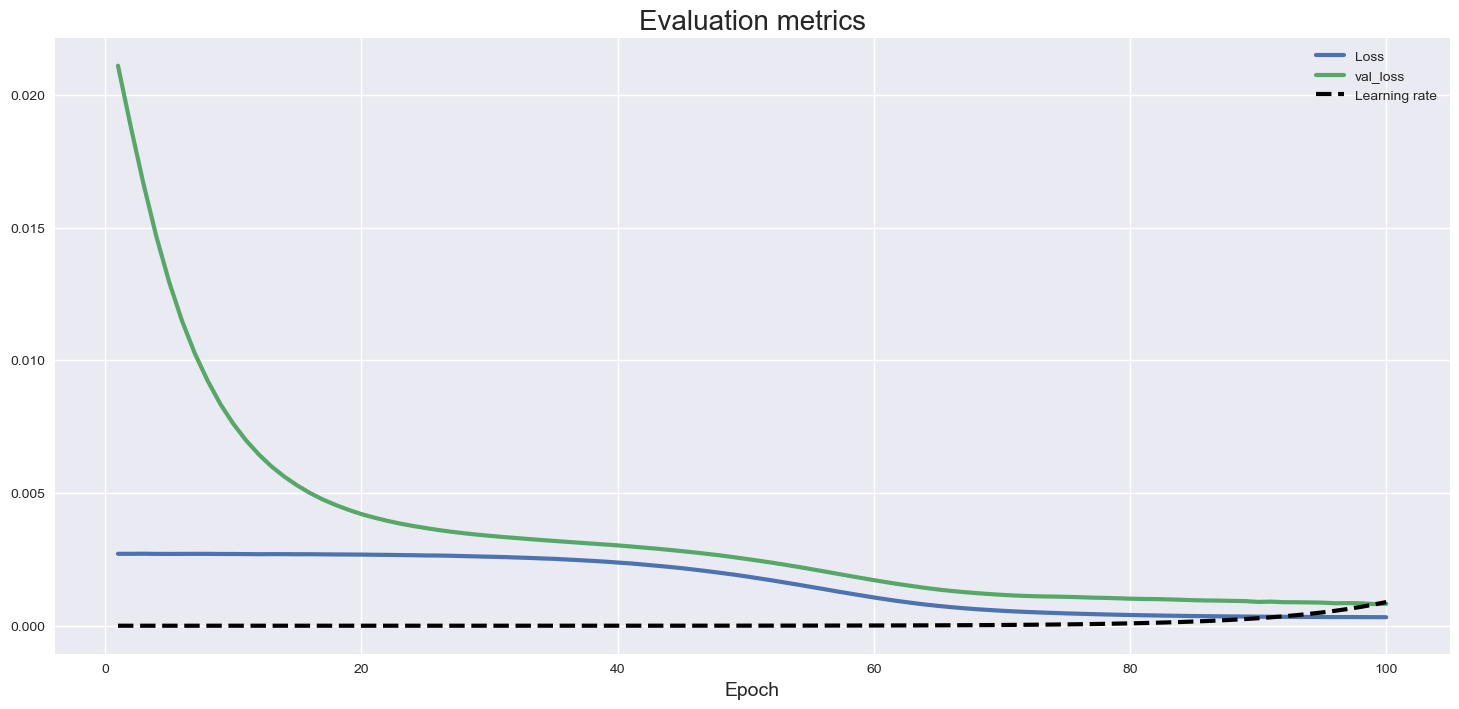

In [40]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
last_epoch = len(history.history['loss'])

plt.plot(np.arange(1, last_epoch+1), history.history['loss'], label='Loss', lw=3)
plt.plot(np.arange(1, last_epoch+1), history.history['val_loss'], label='val_loss', lw=3)
plt.plot(np.arange(1, last_epoch+1), history.history['lr'], label='Learning rate', color='#000', lw=3, linestyle='--')
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()
plt.savefig('eval_vs_lr.jpg', dpi=300, bbox_inches='tight');

In [41]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Batch_Norm_1 (BatchNormali  (None, 5, 96)             384       
 zation)                                                         
                                                                 
 LSTM_1 (LSTM)               (None, 5, 512)            1247232   
                                                                 
 LSTM_2 (LSTM)               (None, 512)               2099200   
                                                                 
 Dense_1 (Dense)             (None, 256)               131328    
                                                                 
 Returns (Dense)             (None, 10)                2570      
                                                                 
Total params: 3480714 (13.28 MB)
Trainable params: 3480522 (13.28 MB)
Non-trainable params: 192 (768.00 Byte)
____________

Text(0.5, 1.0, 'RMSE Loss: Training and Validation')

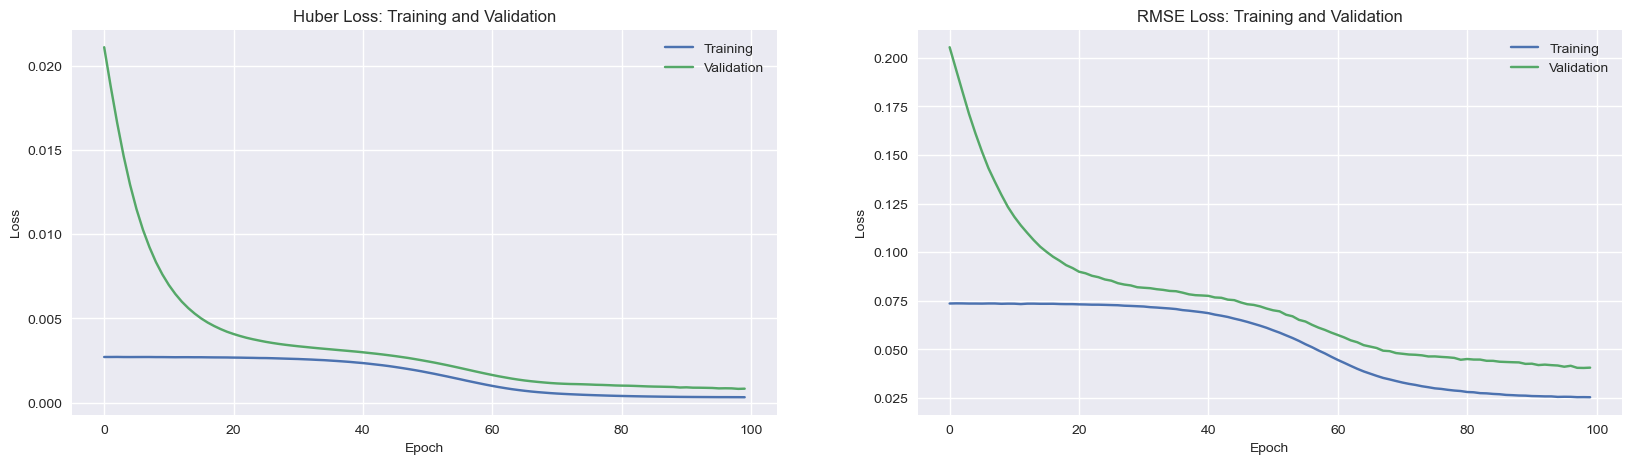

In [42]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training','Validation'])
plt.title('Huber Loss: Training and Validation')
plt.subplot(1,2,2)
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training','Validation'])
plt.title('RMSE Loss: Training and Validation')

In [43]:
model_1.evaluate(my_window.test)

************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 96), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
1/1 [==============================] - 0s 103ms/step - loss: 9.4795e-04 - root_mean_squared_error: 0.0435 - mae: 0.0346


[0.0009479468571953475, 0.043541859835386276, 0.03462986648082733]

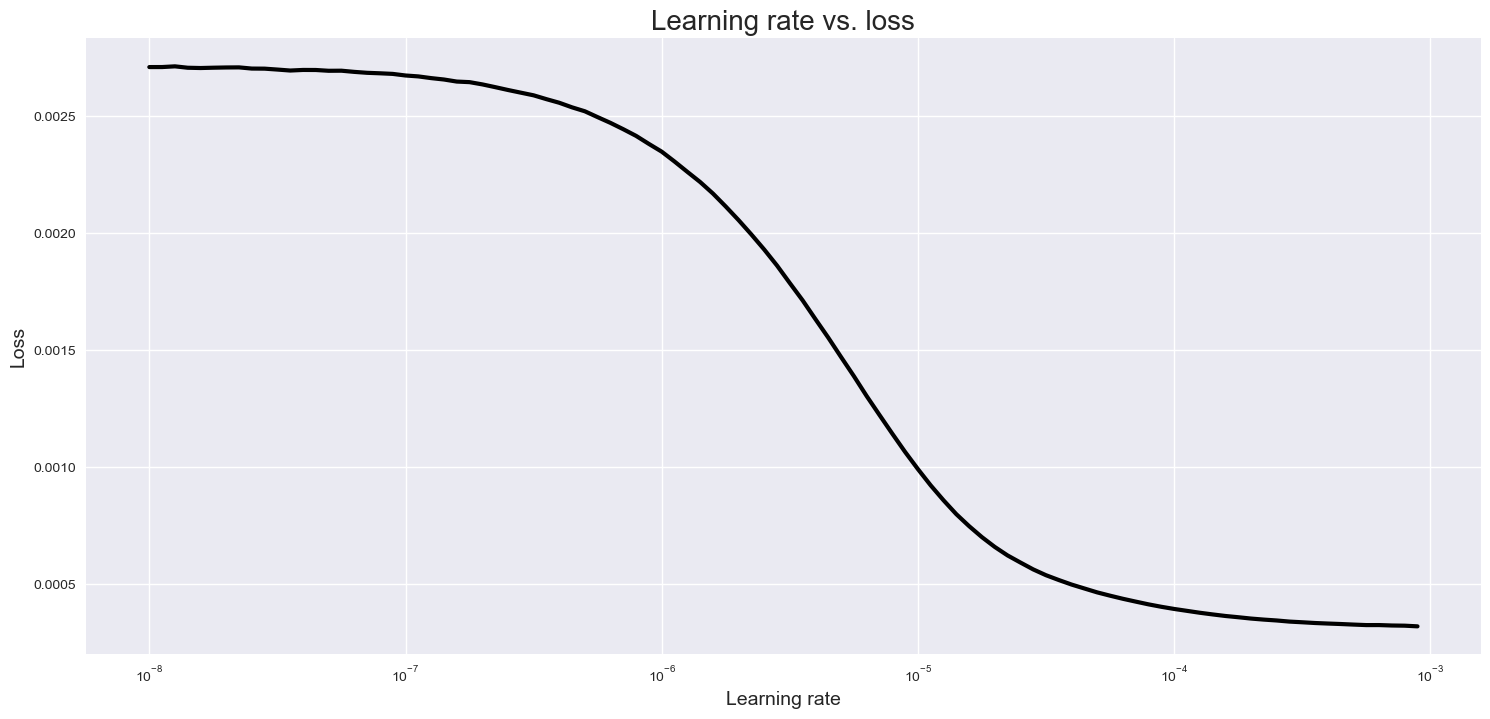

In [44]:
# learning_rates = 1e-8 * (10 ** (np.arange(num_epochs) / 20))
plt.semilogx(history.history['lr'], history.history['loss'], lw=3, color='#000')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)
plt.savefig('lr_vs_loss.jpg', dpi=300, bbox_inches='tight');

In [45]:
def plot_window(tickers,window_dataset,pandas_dataset,window_size,model,
                figsize=(12,100)):
    """This function plots the observed returns inside a tf.data.Dataset and
    compares them with the predicted returns of a model.

    Inputs:
    -------
    window_dataset (tensorflow.data.Dataset object): dataset with both inputs
        and target values.
    pandas_dataset (pandas DataFrame): dataframe that was used to create the
        window_dataset.
    window_size (int): window size used in the transformation from sequential 
        time series into window time series.
    model (model object): trained model with the capability to predict in a
        similar manner than tensorflow.keras.Model object.
    figsize (tuple, default=(12,100)): tuple with the dimensions of the figure
        where the data will be plotted.
    
    Ouputs:
    -------
    None
    """
    # Determine the X-axis of the plot:
    plot_index = pandas_dataset.iloc[window_size:,:].index

    # Assign in the addecuate format the values of the observed taget variable(s):
    y = np.concatenate([targets for inputs,targets in window_dataset],axis=0)
    
    # Use the model to predict the target variable(s):
    
    y_hat = model.predict(window_dataset)
    print("printing y hat of plot_window function")
    print(y_hat)
    # Adjust the shapes:
    y = y.reshape(y_hat.shape)
    print("printing y of plot_window function")
    print(y)

    # Plot the data:
    
    for ticker in tickers:
        for n in range(y_hat.shape[1]):
            plt.figure(figsize=figsize)
            plt.subplot(y_hat.shape[1],1,n+1)
            plt.ylabel('Return')
            plt.plot(plot_index,y_hat[:,n],label='Predicted',color='maroon')
            plt.plot(plot_index,y[:,n],label='Observed',color='midnightblue',alpha=0.5)
            plt.title(ticker)
            plt.legend()

In [57]:
############# Training Results
# Create new WindowGenerator with the data not shuffled:
my_window_2 = WindowGenerator(
    input_width=window_size,
    label_width=1,
    shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=label_cols,
    batch_size=batch_size,
    shuffle=False)

# plot_window(tickers,my_window_2.train,train_df,window_size,model_1)

In [58]:
# plot_window(tickers,my_window_2.test,test_df,window_size,model_1)

In [48]:
def optimize_portfolio(returns,guess_weights=None,rfr=0):
    """This function optimizes the weight allocation for the assets in a
    portfolio, represented by the returns.

    Inputs:
    -------
    returns (pandas DataFrame|Series): contains the returns information.
    guess_weights (list of numerical values, default=None): guess values for
        the weights of the different assets in the portfolio.
    short (boolena, default=True): define ifshort possitions are allowed or 
        not.
    rfr (numerical value, default=0): risk free rate, could be a series of
        the same length as returns.

    Outputs:
    --------
    opt_weights (array-like object): array with the optimal weights for the
        portfolio.
    """
    # Define important variables:
#     print("KIIIIIIII")
    num_assets = returns.shape[1]
    if isinstance(guess_weights,type(None)):
        guess_weights = [1/num_assets for i in range(num_assets)]

    # Define bound if short possitions are allowed or not:
    
    bounds = [(0,1) for i in range(num_assets)]
    

    # Define constraints, if there can or not be leverage
    weights_sum_to_1 = {'type':'eq',
                        'fun':lambda weights: np.sum(np.absolute(weights))-1}
#     print("sharpe ratio:::::::::::")
#     print(sharpe_ratio)
#     print("returns:::::::::::::::")
#     print(returns)
    # Minimize the function:
    opt_weights = spo.minimize(
        sharpe_ratio,
        guess_weights,
        args = (rfr, True, returns),
        method = 'SLSQP',
        options = {'disp':False},
        constraints = (weights_sum_to_1),
        bounds = bounds
    )

    return opt_weights 

In [50]:
def daily_rate(x, periods_year=252):
    """This function transforms a rate into a daily rate

    Inputs:
    -------
    x (numerical value): rate that you want to transform into a daily rate.
    periods_year (numerical value, default=252): amount of periods per year
        of the periodicity of rate x.
    
    Ouputs:
    -------
    df (numerical value): daily rate
    """
    dr = np.power(1+x,1/periods_year)-1
    return dr

In [ ]:
opt_weights = np.array([optimize_portfolio(
    returns = ret_hat_df.columns[:-1],
    rfr = ret_hat_df.columns[-1]).x])

In [54]:
def sharpe_ratio(weights=None, rfr=0, negative=False, returns=0):
    """Compute the Sharpe Ratio of a portfolio.

    Inputs:
    -------
    weights (list of numerical values, default=None): list with the weights
        of the assets in the portfolio.
    rfr (numerical value|array-like, default=0): risk-free rate.
    returns (pandas DataFrame|Series, default=0): returns of the assets in
        the portfolio.

    Outputs:
    --------
    sharpe_ratio (numerical value): Sharpe ratio of the portfolio.
    """
    # Define important variables:
    num_assets = returns.shape[1]
    if isinstance(weights,type(None)):
        weights = [1/num_assets for i in range(num_assets)]

    # Get portfolio returns:
    portfolio_returns = (returns*weights).sum(axis=1)
    portfolio_std = portfolio_returns.std()

    # Compute Sharpe Ratio formula:
    sharpe_ratio = (portfolio_returns-rfr).mean()/portfolio_std

    # If used in a minization process:
    if negative:
        sharpe_ratio *= -1

    return sharpe_ratio    

In [55]:
columns = ['FR_'+ticker for ticker in tickers]
y_train = model_1.predict(my_window_2.train)
y_val = model_1.predict(my_window_2.val)
y_test = model_1.predict(my_window_2.test)
y_hat_total = np.concatenate([y_train,y_val,y_test],axis=0)
ret_hat_df = pd.DataFrame(data=y_hat_total,index=model_data.index[5:],columns=columns)
rfr = data_quandl['3m_rate'].agg(daily_rate)
ret_hat_df = ret_hat_df.merge(rfr.rename('rfr'),left_index=True,right_index=True,
                             how='left')

# opt_weights = np.array([optimize_portfolio(
#     returns = window[ret_hat_df.columns[:-1]],
#     rfr = window[ret_hat_df.columns[-1]]).x for window in ret_hat_df.rolling(40)])
# opt_weights.shape

opt_weights = np.array([optimize_portfolio(
    returns=ret_hat_df[ret_hat_df.columns[:-1]],  # Exclude 'rfr' column
    rfr=ret_hat_df['rfr']
).x])

opt_weights = opt_weights.squeeze()  # Remove extra dimension if it exists

# Display the shape of opt_weights
print(f"Shape of optimized weights: {opt_weights.shape}")


************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 96), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
6/6 [==============================] - 0s 60ms/step
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 96), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
2/2 [==============================] - 0s 42ms/step
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 96), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 10), dtype=tf.float32, name=None))>
1/1 [==============================] - 0s 90ms/step
sharpe ratio:::::::::::
<function sharpe_ratio at 0x28b197d90>
returns:::::::::::::::
              FR_DIS   FR_BIIB    FR_PGR    FR_SWK    FR_PEP   FR_ZION  \
Date                                                                     
2007-02

In [56]:
opt_weights

array([0.00000000e+00, 1.55726199e-01, 1.90072352e-01, 2.82022874e-17,
       0.00000000e+00, 1.36996239e-01, 4.31821526e-17, 0.00000000e+00,
       1.57300536e-01, 3.59904675e-01])

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Define the stocks and download data
# stocks = ["AAPL", "MSFT", "GOOGL"]
start_date = "2007-01-04"
end_date = "2021-01-05"

# stock_data = yf.download(stocks, start=start_date, end=end_date)

# Extract the adjusted closing prices
# prices = stock_data['Adj Close']

# Calculate daily returns as percentage change
# returns = prices.pct_change().dropna()

# Split the data into training and testing sets (70:30)
# train_size = int(len(model_data) * 0.7)
# train_data, test_data = model_data[:train_size], model_data[train_size:]

# Loop through each stock and perform ARIMA analysis
for ticker in tickers:
    print(f"ARIMA analysis for {ticker}:")
    
    # Create a dataframe for the specific stock's returns
    stock_returns = model_data[ticker+"_close"].dropna()
    
    # Split the data into training and testing sets
    train_size = int(len(stock_returns) * 0.7)
    train_data, test_data = stock_returns[:train_size], stock_returns[train_size:]
    
    # Fit ARIMA model
    model = ARIMA(train_data, order=(5,1,0))
    model_fit = model.fit()
    
    # Make one-step ahead predictions for percentage change
    predictions = model_fit.forecast(steps=len(test_data))
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, test_data.values, label='Actual Percentage Change')
    plt.plot(test_data.index, predictions, color='red', label='ARIMA Predictions')
    plt.title(f'{ticker} Stock Percentage Change ARIMA Prediction')
    plt.xlabel('Date')
    plt.ylabel('Percentage Change')
    plt.legend()
    plt.show()
    
    # Calculate Mean Absolute Error (MAE) as a measure of model accuracy
    mae = np.mean(np.abs(predictions - test_data.values))
    print(f"Mean Absolute Error (MAE) for {ticker}: {mae:.4f}")
